## Import Standard Package

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Import Time Series Data : Airline Passenger Traffic

In [2]:
# Since the data set doesn't have any columns
data = pd.read_csv('airline-passenger-traffic.csv',header=None)
data.head(2)

,0,1
0,1949-01,112.0
1,1949-02,118.0


In [3]:
data.columns = ['Month','Passengers']
data.head(2)

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  140 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


### Converting the month column from Object to date format

In [5]:
# Since the value is 4 digit year value and 2 digit month value Y and m respectively
data['Month'] = pd.to_datetime(data['Month'],format='%Y-%m')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  140 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


## Plot before setting month as index

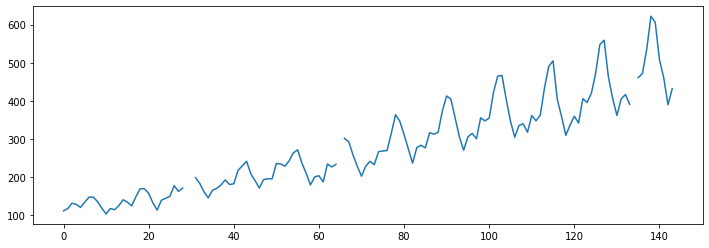

In [7]:
plt.figure(figsize=(12,4))
plt.plot(data['Passengers'])
plt.show()

### Setting month column as index

In [8]:
data.set_index('Month',inplace=True)

In [9]:
data.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


Here the date is also added, by default first date of month

# Time Series Analysis

## Plot time series data

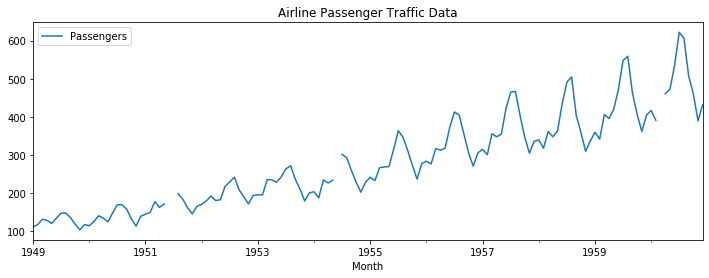

In [10]:
data.plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Airline Passenger Traffic Data')
# Use the keyword 'block' to override the blocking behavior : Computation will not be blocked
plt.show(block=False)

From the graph we can infer that:
- Number of passengers is increasing over the years
- Also each year we can see seasonal trend(increase and decrease)
- There are some missing values in the data

## Since we have given the date values as index(and it is in date format) , we are getting the years value in the X axis or else we would've got the index value 0,1,2,... in X axis.

# <span style='color:purple'> Handling Missing Values

## Missing Value Treatment

### Mean Imputation

We are creating a new column `Passengers_Mean_Imputation` it contains the mean where ever the missing values are presnet in the column.

In [11]:
data = data.assign(Passengers_Mean_Imputation = data.Passengers.fillna(data.Passengers.mean()))

In [12]:
data.head(2)

,Passengers,Passengers_Mean_Imputation
Month,,
1949-01-01,112.0,112.0
1949-02-01,118.0,118.0


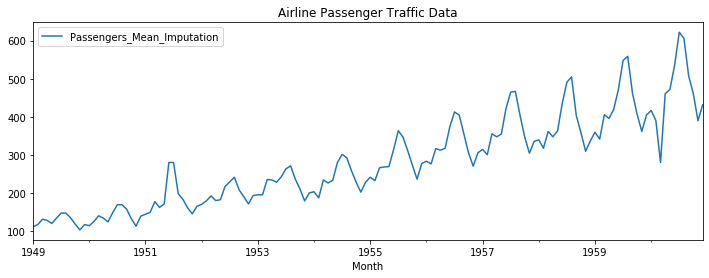

In [13]:
data[['Passengers_Mean_Imputation']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Airline Passenger Traffic Data')
# Use the keyword 'block' to override the blocking behavior : Computation will not be blocked
plt.show(block=False)

The missing values are replaced with mean

### Linear Interpolation

In [14]:
data = data.assign(Passengers_Linear_Interpolation = data.Passengers.interpolate(method='linear'))

In [15]:
data.head(2)

,Passengers,Passengers_Mean_Imputation,Passengers_Linear_Interpolation
Month,,,
1949-01-01,112.0,112.0,112.0
1949-02-01,118.0,118.0,118.0


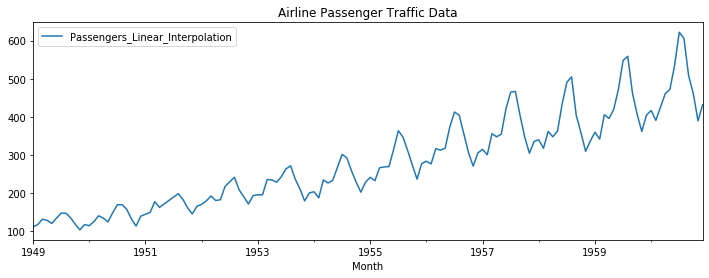

In [16]:
data[['Passengers_Linear_Interpolation']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Airline Passenger Traffic Data')
# Use the keyword 'block' to override the blocking behavior : Computation will not be blocked
plt.show(block=False)

For practical purposes , linear interpolation works better in our case.

In [17]:
data['Passengers'] = data['Passengers_Linear_Interpolation']
data['Passengers'].isna().sum()

0

# <span style='color:purple'>Handling Outliers

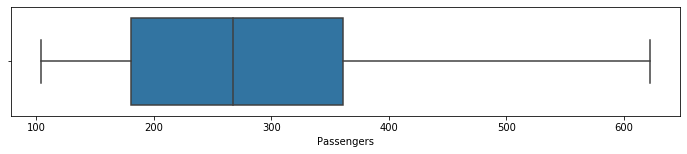

In [28]:
import seaborn as sns
fig = plt.subplots(figsize=(12,2))
ax = sns.boxplot(x = data['Passengers'], whis = 1.5)
plt.show()

No outliers are present

## Histogram Plot

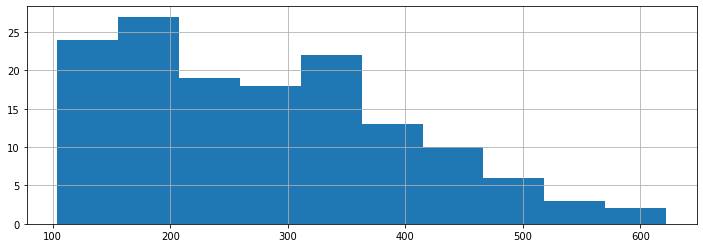

In [29]:
fig = data.Passengers.hist(figsize = (12,4))

No discountinued bar, so no outliers

# <span style='color:purple'>Additive and Multiplicative Decomposition

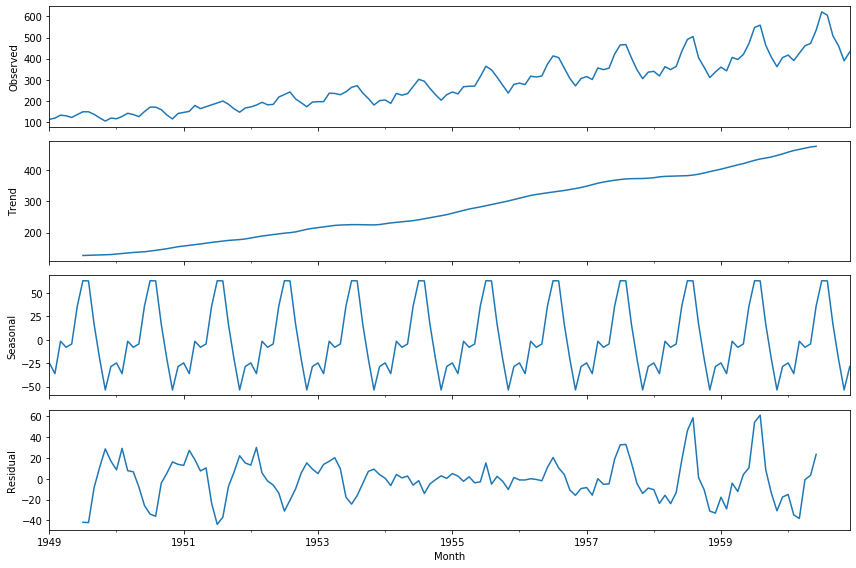

In [30]:
import statsmodels.api as sm
# For figure size
from pylab import rcParams
rcParams['figure.figsize'] = 12,8
# tsa stands for Time Series Analysis
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='additive')
fig = decomposition.plot()
plt.show()

-  **Observed** : It is exact same series we got earlier.
- **Trend** : Trend captures that Over all trend is upwards.
- **Seasonal** : The absolute movement within a year, is very repeatable fashion. **NOTICE the units are from -50 to +50** which says what need to be added or subracted to the trend to get the original graph.
- **Residual** : what ever not gets captured by Trend and Seasonal is captured by **Residual**. <br/>

## <center>Observed = Trend + Seasonal + Residual

### <span style='color:blue'> Even after capturing seasonality, we have some seasonal effect continue to be visible in the Residual part of the data, which means that we can do better with different type of seasonality.

- With respect to the air passenger example: The number of passengers are increased with increase in Year. So if we add the constant number like we did in Additive Decomposition, it won't be precise.<br/>
Example: Number of passenger at 1951 is 150, 
    - we got trend as **160** 
    - Seasonal **-30**
    - Residual **+20**
 <br/> 
Number of Passengers at 1959 is 350,
    - we got trend as **400** 
    - Seasonal **-30**
    - Residual <span style='color:red'>**-20**</span>

### Here instead of Seasonal and trend giving the observed value, Residual is also playing a major role, which can be done well with different **Seasonal**.
- So we need multiplicative decomposition, where we will multiply with the trend.

### <span style='color:red'> Additive Decomposition fails if there is a slight non linear trend in the data.This is because the magnitude of the seasonal pattern in the data increases as thus additive decompsition will not be able to capture the non-linearity.

# Multiplicative Decomposition

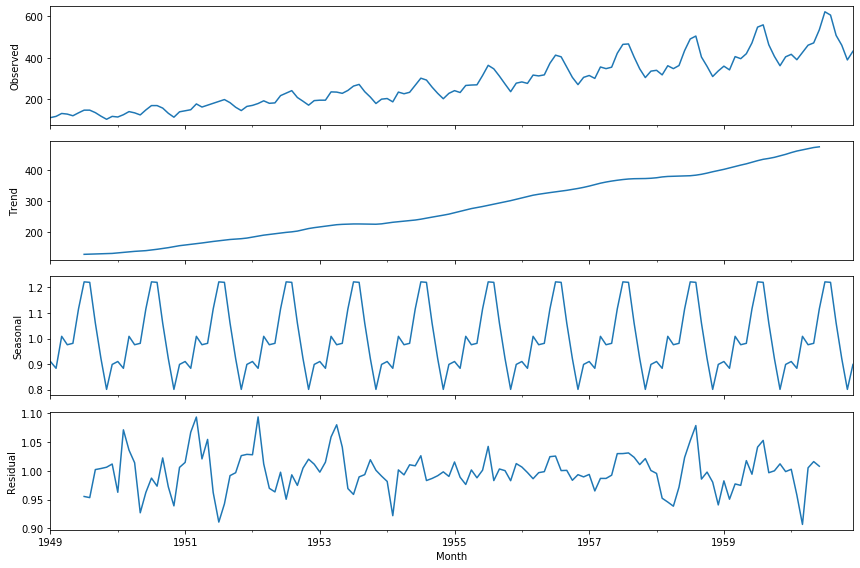

In [31]:
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='multiplicative')
fig = decomposition.plot()
plt.show()

-  **Observed** : It is exact same series we got earlier.
- **Trend** : Trend captures that Over all trend is upwards. It is very similar to additive decomposition.
- **Seasonal** : The absolute movement within a year, is very repeatable fashion. **NOTICE the units are from -0.8 to 1.2** which says what need to be <span style='color:red'>**Multiplied**</span> to the trend to get the original graph.
- **Residual** : what ever not gets captured by Trend and Seasonal is captured by **Residual**. It needs to be multiplied with Trend.<br/>
The Residuals are more random, i.e., less systematic patterns.

## Build and evaluate time series forecast

### Splitting the time series into Training and Test sets 

In [32]:
# First 120 rows of historical data is considered as training set
train_len = 120

In [33]:
train = data[0:train_len]
test = data[train_len:]

NOTE: Here we cannot use any random state and split the data in random fashion, as Time Series analysis will give different forecasts for the orginal data and for the shuffled one.

# Naive Method

In [34]:
# Copying test data frame to y_hat_naive because naive method need to 
#predicts for the test data frame.
y_hat_naive = test.copy()

In [35]:
#Create a new column naive_forecast which contains last observation in the train set
y_hat_naive['naive_forecast'] = train['Passengers'][train_len-1]

## Plot the predictions

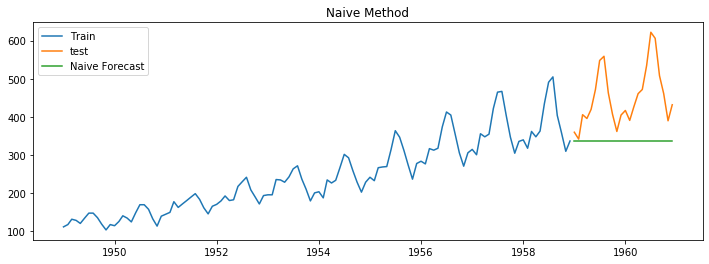

In [36]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive Forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

**From the graph it is clear that the predictions are underfitting.**

# Simple Average Method

In [37]:
# Copying test data frame to y_hat_naive because Simple Average  method need to 
#predicts for the test data frame.
y_hat_avg = test.copy()

In [38]:
#Create a new column avg_forecast which contains mean of the train data set
y_hat_avg['avg_forecast'] = train['Passengers'].mean()

# Plot Train test and Average Forecast

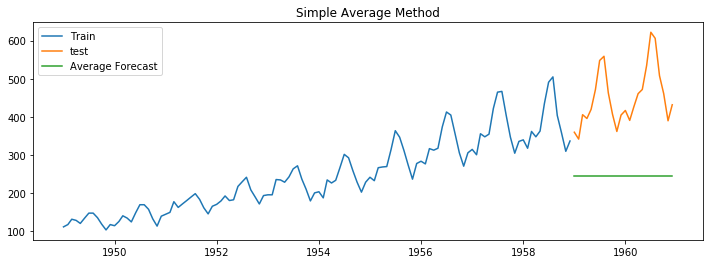

In [39]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

### From the graph it is clear that it didn't recognise the trend and seasonality in both Train and Test data.

# Calculate RMSE and MAPE to evaluate forecast

## For Naive Method

In [40]:
from sklearn.metrics import mean_squared_error
# mean_squared_error gives MSE , since we need RMSE take square root of MSE
rmse = np.sqrt(mean_squared_error(test['Passengers'],y_hat_naive['naive_forecast'])).round(2)
rmse

137.51

In [41]:
# To Calculate MAPE
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_naive['naive_forecast'])/test['Passengers'])*100,2)
mape

23.63

In [42]:
# Remeber to add [] for the value in the dictionary
results = pd.DataFrame({'Method':['Naive Method'],'RMSE':[rmse],'MAPE':[mape]})
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63


The `MAPE` is 23.63 which means that 76.37 is the accuracy.

## For Simple Average 

In [43]:
from sklearn.metrics import mean_squared_error
# mean_squared_error gives MSE , since we need RMSE take square root of MSE
rmse = np.sqrt(mean_squared_error(test['Passengers'],y_hat_avg['avg_forecast'])).round(2)
rmse

219.69

In [44]:
# To Calculate MAPE
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_avg['avg_forecast'])/test['Passengers'])*100,2)
mape

44.28

In [45]:
tempResults = pd.DataFrame({'Method':['Simple Average Method'],'RMSE':[rmse],'MAPE':[mape]})
# Note important to add []
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28


### <span style='color:green'> After comparing the 2 method errors, it is clear that Naive method error is less and hence it is better compared to simple average method.

# Simple Moving Average Method

In [61]:
#Here we are copying the whole data , previously we split the data into train and test
# As we want to show how the prediction is even for the train data
y_hat_sma = data.copy()

In [62]:
# Moving average window
ma_window = 12

In [63]:
# Take the 12 months data and calculate mean
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()

### Updating the test forecast value, as test data is always unseen

Copying the forecast value of last train data to all the test data.

In [64]:
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

## Plot train,test and forecast

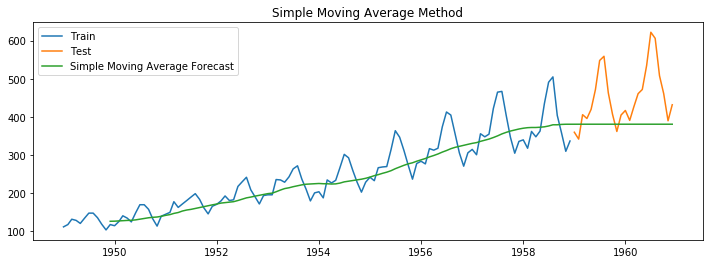

In [65]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple Moving Average Forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

- This forecast is better than Simple average or naive based method.
- Trend is captured as we are taking 12 months recent mean.
- Seasonality in the year is not captured.

# Calculate RMSE and MAPE to evaluate forecast

In [66]:
# mean_squared_error gives MSE , since we need RMSE take square root of MSE
# Since we are calculating for the whole data set, we need to select only test data in y_hat_sma
rmse = np.sqrt(mean_squared_error(test['Passengers'],
                                       y_hat_sma['sma_forecast'][train_len:])).round(2)
rmse

103.33

In [67]:
# To Calculate MAPE
#we need to select only test data in y_hat_sma
mape = np.round(np.mean(np.abs(test['Passengers'] - 
                               y_hat_sma['sma_forecast'][train_len:])/test['Passengers'])*100,2)
mape

15.54

In [68]:
tempResults = pd.DataFrame({'Method':['Simple Moving Average Method'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28
0,Simple Moving Average Method,103.33,15.54


It is clear that Simple Moving Average method is better compared to Simple Average Method and Naive Method.

# Changing the moving average to 6 months

In [69]:
# Moving average window
ma_window = 6

In [70]:
# Take the 6 months data and calculate mean
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()

### Updating the test forecast value, as test data is always unseen

Copying the forecast value of last train data to all the test data.

In [71]:
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

## Plot train,test and forecast

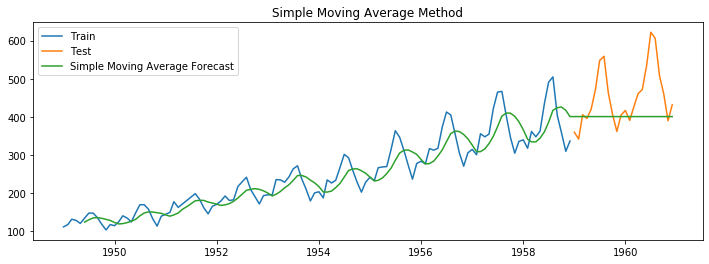

In [72]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple Moving Average Forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

- Green line started to capture some amount of seasonal patterns along with Trend.
- It perfomed also well on the test data.

## <span style='color:blue'>If there was noise in the data , then choosing smaller window is not a good option. Here this issue is not encountered.

# Changing the moving average to 3 months

In [73]:
# Moving average window
ma_window = 3

In [74]:
# Take the 12 months data and calculate mean
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()

### Updating the test forecast value, as test data is always unseen

Copying the forecast value of last train data to all the test data.

In [75]:
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

## Plot train,test and forecast

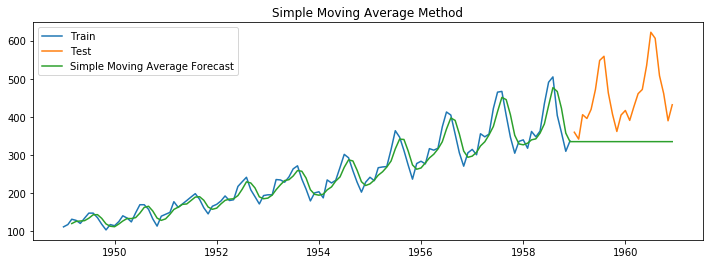

In [76]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple Moving Average Forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

- Green line started to capture yearly seasonal patterns along with Trend.
- **But it underperformed on the test data.**

# Just to see if we choose 60 months

In [77]:
# Moving average window
ma_window = 60

In [78]:
# Take the 12 months data and calculate mean
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()

### Updating the test forecast value, as test data is always unseen

Copying the forecast value of last train data to all the test data.

In [79]:
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

## Plot train,test and forecast

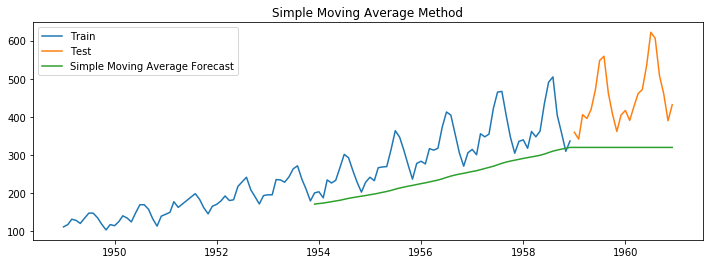

In [80]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple Moving Average Forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

- It is not capturing the trend or seasonality and not performing well on the test data.

### <span style='color:green'> To filter out the noise and learn the long trend, 12 months window is better.<br/> Stil we have some issue with simple moving average, it is not capturing the seasonality within a year, so we need to look after some method.

# Simple Exponential Smoothing

In [93]:
# SimpleExpSmoothing is available in holtwinters package
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Assigning the train data
model = SimpleExpSmoothing(train['Passengers'])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


- `smoothing_level` is the alpha parameter
- Here the `optimizied` is given false , if its true then no need to give value for `smoothing_level`

In [94]:
# Fit the model on train data
model_fit = model.fit(smoothing_level=0.2,optimized=False)
#To get the parameters 
model_fit.params

{'smoothing_level': 0.2,
 'smoothing_slope': None,
 'smoothing_seasonal': None,
 'damping_slope': nan,
 'initial_level': 112.0,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

- Copying the test data to `y_hat_ses`, 
- **`forecast`** value is given 24 as we need to forecast for the 24 months which are present in the test data

In [95]:
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24)

## Plot train,test and forecast

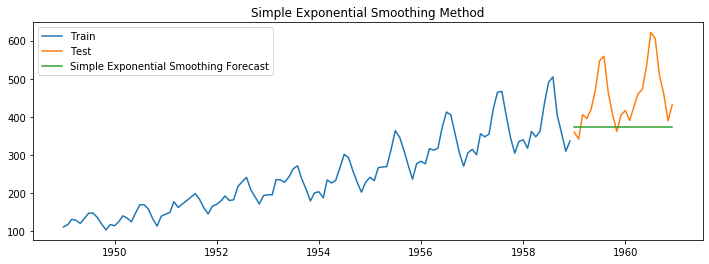

In [96]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple Exponential Smoothing Forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

- Here we are **not** capturing trend : it would have been a line with slope
- Also we are **not** capturing seasonality.
- Here we are capturing the **LEVEL**.

# Calculate RMSE and MAPE to evaluate forecast

In [97]:
# mean_squared_error gives MSE , since we need RMSE take square root of MSE
# Since we are calculating for the whole data set, we need to select only test data in y_hat_sma
rmse = np.sqrt(mean_squared_error(test['Passengers'],
                                       y_hat_ses['ses_forecast'])).round(2)
rmse

107.65

In [98]:
# To Calculate MAPE
#we need to select only test data in y_hat_sma
mape = np.round(np.mean(np.abs(test['Passengers'] - 
                               y_hat_ses['ses_forecast'])/test['Passengers'])*100,2)
mape

16.49

In [99]:
tempResults = pd.DataFrame({'Method':['Simple Exponential Smoothing Method'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28
0,Simple Moving Average Method,103.33,15.54
0,Simple Exponential Smoothing Method,107.65,16.49


From the above data frame it is inferred that Simple Exponential Smoothing Method is not better than Simple Moving Average Method. So let's try changing the alpha value.

## Finding the optimal value of alpha

As the alpha value increases, it increases the weight of the recent observation.

#### Let's try with alpha = 0.4

In [100]:
# SimpleExpSmoothing is available in holtwinters package
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Assigning the train data
model = SimpleExpSmoothing(train['Passengers'])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [101]:
# Fit the model on train data
model_fit = model.fit(smoothing_level=0.2,optimized=False)
#To get the parameters 
#model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24)

## Plot train,test and forecast

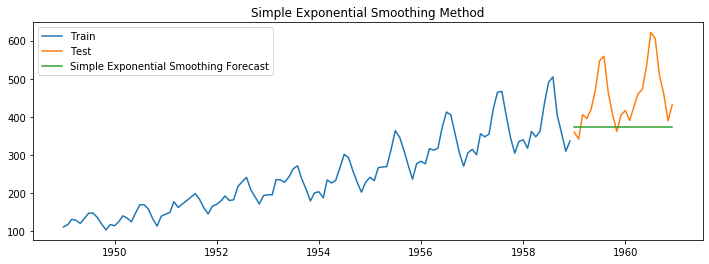

In [102]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple Exponential Smoothing Forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

-  The forecast line has decreased. As the last value in the train data is of low value.As alpha is high so more weight for the last value.

## Let's try with alpha = 1

In [103]:
# SimpleExpSmoothing is available in holtwinters package
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Assigning the train data
model = SimpleExpSmoothing(train['Passengers'])
# Fit the model on train data

model_fit = model.fit(smoothing_level=1,optimized=False)

#To get the parameters 
#model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


## Plot train,test and forecast

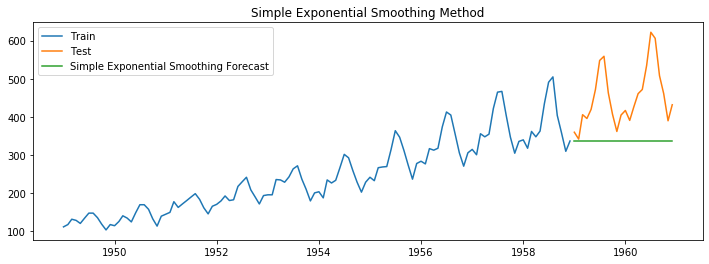

In [104]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple Exponential Smoothing Forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

### <span style='color:blue'> This is same as the naive based method. Here since alpha value is 1 , 1 is multiplied with last value and 0 with remaining values.

## Let's try with alpha with very low value say 0.0001

In [105]:
# SimpleExpSmoothing is available in holtwinters package
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Assigning the train data
model = SimpleExpSmoothing(train['Passengers'])
# Fit the model on train data

model_fit = model.fit(smoothing_level=0.0001,optimized=False)

#To get the parameters 
#model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


## Plot train,test and forecast

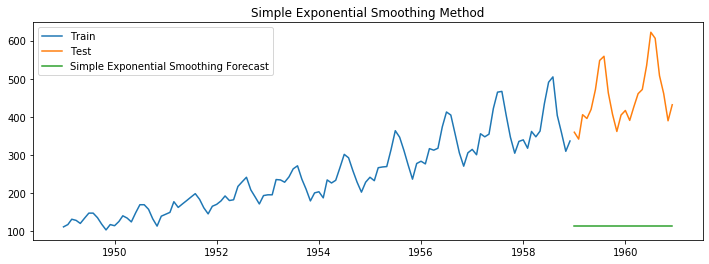

In [106]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple Exponential Smoothing Forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

### <span style='color:blue'>Then the forecast is very close to the early values, as very less weight is given to latest observation.

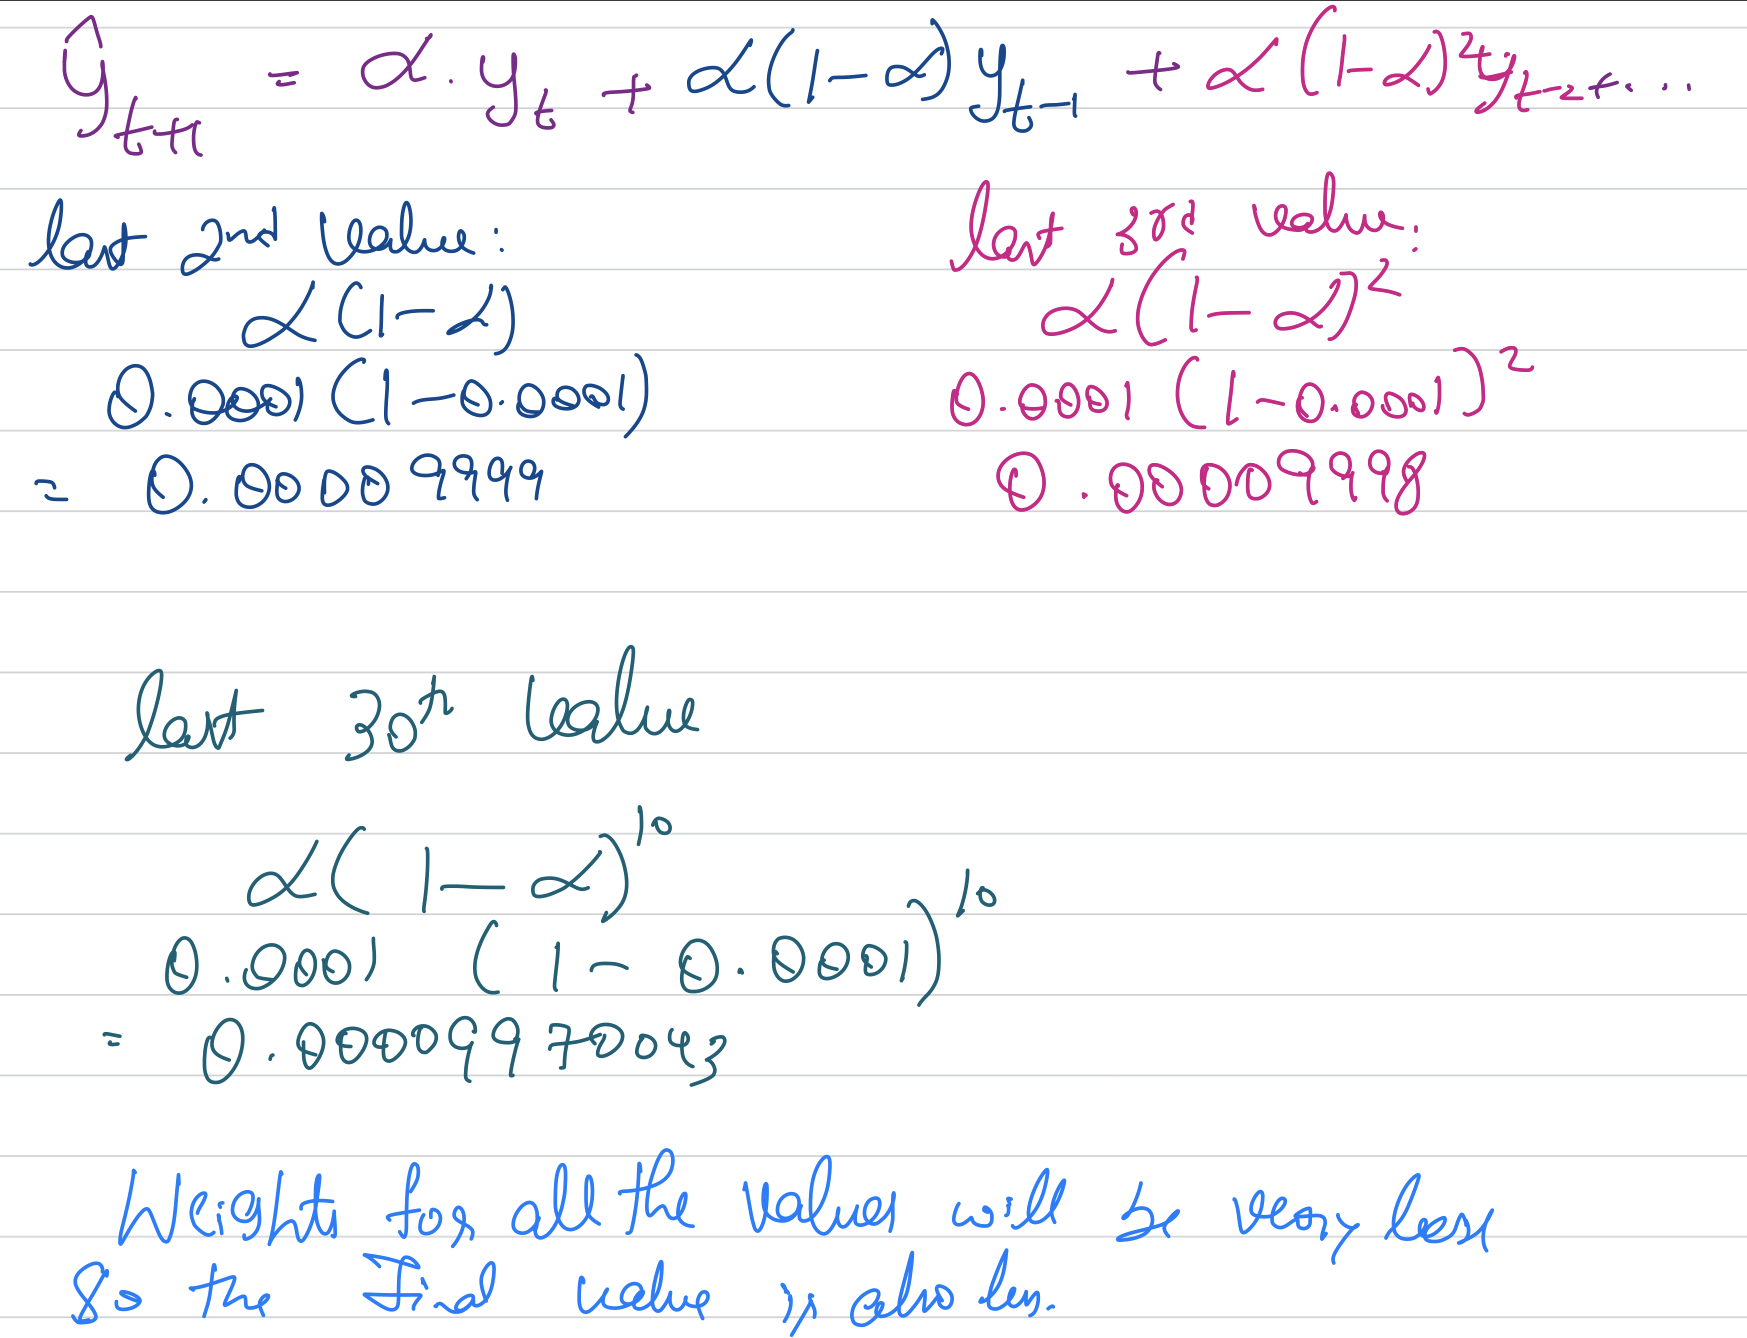

### From the above alpha values , alpha = 0.2 was giving better values.

# <span style='color:#0099cc'>Holt's exponential smoothing method with Trend

In [107]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

- We fit the model with Train data and 
- we need to pass as an np.array, so we converting the data frame into array using **`np.asarray`**
- `seasonal_periods` is 12, to mention that for every 12 months we are expecting to see seasonality.<span style='color:red'> **However Holts exponential smoothing will not consider seasonality , simply we are mentioning.**</span>
- `trend` here we are giving **additive** as based on previous analysis, we found that training data follows linear trend. For linear trend additive decomposition works better. For exponential we will use multiplicative trend.
- `seasonal` is None as we are not capturing the seasonality.( will do that next)

In [108]:
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods = 12,
                             trend='additive',
                            seasonal=None)

- We have defined the model, now we need to Fit the model,with alpha and beta value which is `smoothing_level` and `smoothing_slope`. 
- Here `optimized` is flase as we are explicitly providing the alpha and beta values.
- `smoothing_level`=**0.2** means that the last value is given a weight of 0.2
- `smoothing_slope`=**0.01** means that we are assigning this weight to the difference between last 2 consecutive values.(slope) and gradually this weight will decrease for the remaining differences.
<span style='color=blue'>The reason for the low value of `smoothing_slope` is that it shouldn't drive the forecast up down too much with the seasonality, as the curve increase is due to year on year wise not on month on month basis.

In [109]:
model_fit = model.fit(smoothing_level=0.2,smoothing_slope=0.01,optimized=False)

In [110]:
model_fit.params

{'smoothing_level': 0.2,
 'smoothing_slope': 0.01,
 'smoothing_seasonal': None,
 'damping_slope': nan,
 'initial_level': 112.0,
 'initial_slope': 6.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

`initial_level` is 112, the level we get is 112 and<br/> `'initial_slope': 6.0` is that first slope between 2 months is 6

#### Now forecasting on the test data.

In [111]:
y_hat_holt = test.copy()

As test period is 24 months , we need to predict for those months.

In [112]:
y_hat_holt['holt_forecast'] = model_fit.forecast(24)

## Plot train,test and forecast

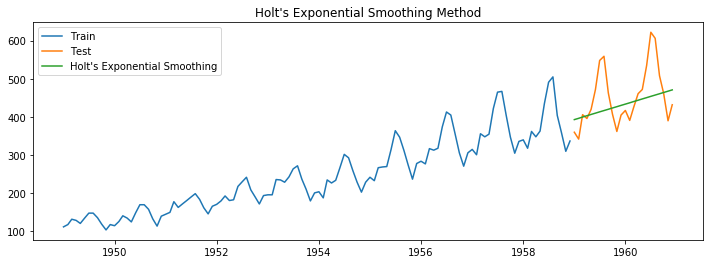

In [113]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s Exponential Smoothing')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

There is a straight line with slope as we are considering both level and trend.

# Calculate RMSE and MAPE to evaluate forecast

In [114]:
# mean_squared_error gives MSE , since we need RMSE take square root of MSE
# Since we are calculating for the whole data set, we need to select only test data in y_hat_sma
rmse = np.sqrt(mean_squared_error(test['Passengers'],
                                       y_hat_holt['holt_forecast'])).round(2)
rmse

71.94

In [115]:
# To Calculate MAPE
#we need to select only test data in y_hat_sma
mape = np.round(np.mean(np.abs(test['Passengers'] - 
                               y_hat_holt['holt_forecast'])/test['Passengers'])*100,2)
mape

11.11

In [116]:
tempResults = pd.DataFrame({'Method':['Holt\'s Exponential Smoothing Method'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28
0,Simple Moving Average Method,103.33,15.54
0,Simple Exponential Smoothing Method,107.65,16.49
0,Holt's Exponential Smoothing Method,71.94,11.11


### <span style='color:green'>Compared to other methods this gives the lowest RMSE and MAPE.

## <span style='color:#0099cc'> Let's try with higher `Smoothing_slope`

In [117]:
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods = 12,
                             trend='additive',
                            seasonal=None)
model_fit = model.fit(smoothing_level=0.2,smoothing_slope=0.1,optimized=False)
model_fit.params
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(24)

## Plot train,test and forecast

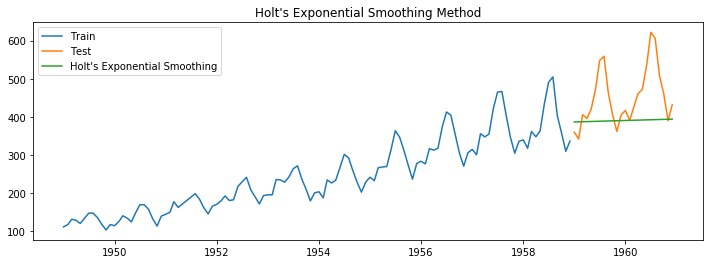

In [118]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s Exponential Smoothing')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

As we change the slope from 0.01 to 0.1 we can see a flat line, as we are giving more weight to the recent slope. **In the train data the slope of last 2 values is very less, so that value is forecasted in test data.** Thus it is cancelling the remaining slopes values with lower weights.

## <span style='color:#0099cc'> Let's try with lesser `Smoothing_slope`

In [119]:
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods = 12,
                             trend='additive',
                            seasonal=None)
model_fit = model.fit(smoothing_level=0.2,smoothing_slope=0.001,optimized=False)
model_fit.params
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(24)

## Plot train,test and forecast

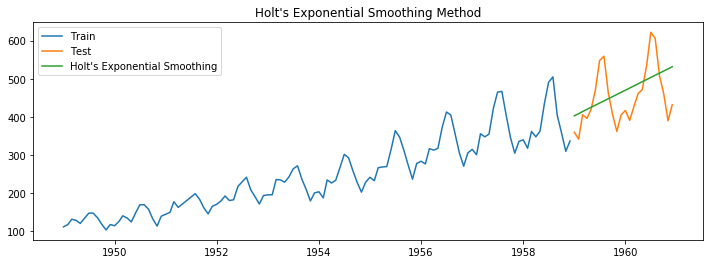

In [120]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s Exponential Smoothing')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

- Lower the value , better we are capturing the overall trend.
- Higher the value, we are capturing the recent trend. <br/>
We need to find a balance between these 2. **0.01** works fine.

### <span style='color:green'> With Holt's we are able to capture Level and Trend. </span><span style='color:red'>Only thing we need to capture is Seasonality.

# <span style='color:#0099cc'> Holt Winters's Additive Method with Trend and Seasonality

- We fit the model with Train data and 
- we need to pass as an np.array, so we converting the data frame into array using **`np.asarray`**
- `seasonal_periods` is 12, to mention that for every 12 months we are expecting to see seasonality.<span style='color:red'> **However Holts exponential smoothing will not consider seasonality , simply we are mentioning.**</span>
- `trend` here we are giving **additive** as based on previous analysis, we found that training data follows linear trend. For linear trend additive decomposition works better. For exponential we will use multiplicative trend.
- `seasonal` is **additive**.

Note: You can mention **additive** or even **add**.

In [121]:
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods = 12,
                             trend='additive',
                            seasonal='additive')

- We have defined the model, now we need to Fit the model,with alpha and beta value which is `smoothing_level` and `smoothing_slope`. 
- Here `optimized` is flase as we are explicitly providing the alpha and beta values.
- `smoothing_level`=**0.2** means that the last value is given a weight of 0.2
- `smoothing_slope`=**0.01** means that we are assigning this weight to the difference between last 2 consecutive values.(slope) and gradually this weight will decrease for the remaining differences.
<span style='color=blue'>The reason for the low value of `smoothing_slope` is that it shouldn't drive the forecast up down too much with the seasonality, as the curve increase is due to year on year wise not on month on month basis.</span>
- `smoothing_seasonal` to give weight to the seasonality
### <span style='color:blue'> Here we are first trying with `optimized=True` to get the better value of alpha, beta and gamma.

In [122]:
# model_fit = model.fit(smoothing_level=0.2,smoothing_slope=0.01,smoothing_seasonal = 0.1, optimized=False)

In [123]:
model_fit = model.fit(optimized=True)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [124]:
model_fit.params

{'smoothing_level': 0.26315789314098964,
 'smoothing_slope': 0.05162964592350308,
 'smoothing_seasonal': 0.7368421036673054,
 'damping_slope': nan,
 'initial_level': 211.55098651691858,
 'initial_slope': 1.7392009583680696,
 'initial_seasons': array([-100.18118124,  -94.2046449 ,  -80.29175411,  -83.4175839 ,
         -91.45908162,  -77.45094413,  -64.48324476,  -64.57340812,
         -76.66644557,  -93.73584622, -108.6761136 ,  -94.50947864]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

- 'smoothing_level': 0.26315789314098964,       -> **alpha**
- 'smoothing_slope': 0.05162964592350308,       -> **Beta**
- 'smoothing_seasonal': 0.7368421036673054,     -> **Gamma**<br/>
`initial_level` is 110, the first level we get is 112 and<br/> `'initial_slope': 1.89` is that first slope between 2 months is 1.89
- 'initial_seasons': array([-100.18118124,  -94.2046449 ,  -80.29175411,  -83.4175839 ,
         -91.45908162,  -77.45094413,  -64.48324476,  -64.57340812,
         -76.66644557,  -93.73584622, -108.6761136 ,  -94.50947864]),
As it contains +ve and -ve it means that we have used additive method

#### Now forecasting on the test data.

In [125]:
y_hat_hwa = test.copy()

As test period is 24 months , we need to predict for those months.

In [126]:
y_hat_hwa['hwa_forecast'] = model_fit.forecast(24)

## Plot train,test and forecast

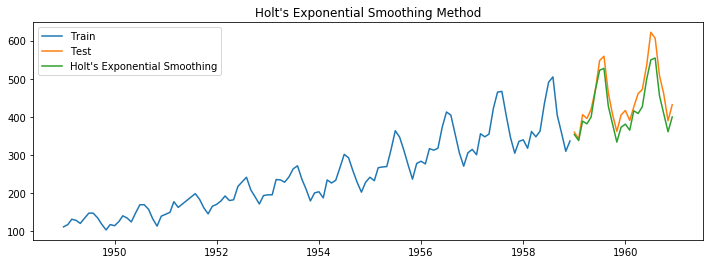

In [127]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_hwa['hwa_forecast'], label='Holt\'s Exponential Smoothing')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

### <span style='color:green'>From the output we can see that there is a good capture of Level, Trend and Seasonality.Previously we used to get only the straight line with a slope, now it is able to capture even the seasonality. </span><span style='color:red'>The peak is little lagging, we will look into to how to improve that.

# Calculate RMSE and MAPE to evaluate forecast

In [128]:
# mean_squared_error gives MSE , since we need RMSE take square root of MSE
# Since we are calculating for the whole data set, we need to select only test data in y_hat_sma
rmse = np.sqrt(mean_squared_error(test['Passengers'],
                                       y_hat_hwa['hwa_forecast'])).round(2)
rmse

35.1

In [129]:
# To Calculate MAPE
#we need to select only test data in y_hat_sma
mape = np.round(np.mean(np.abs(test['Passengers'] - 
                               y_hat_hwa['hwa_forecast'])/test['Passengers'])*100,2)
mape

6.53

In [130]:
tempResults = pd.DataFrame({'Method':['Holt\'s Winters\'s Smoothing Method'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28
0,Simple Moving Average Method,103.33,15.54
0,Simple Exponential Smoothing Method,107.65,16.49
0,Holt's Exponential Smoothing Method,71.94,11.11
0,Holt's Winters's Smoothing Method,35.10,6.53


### <span style='color:green'>Compared to other methods this gives the much lower RMSE and MAPE.

# <span style='color:#0099cc'> Holt Winters's `Multiplicative` Method with Trend and Seasonality

- We fit the model with Train data and 
- we need to pass as an np.array, so we converting the data frame into array using **`np.asarray`**
- `seasonal_periods` is 12, to mention that for every 12 months we are expecting to see seasonality.<span style='color:red'> **However Holts exponential smoothing will not consider seasonality , simply we are mentioning.**</span>
- `trend` here we are giving **additive** as based on previous analysis, we found that training data follows linear trend. For linear trend additive decomposition works better. For exponential we will use multiplicative trend.
- `seasonal` is **multiplicative**.

Note: You can mention **additive** or even **add** and **multiplicative** or **mul**

In [131]:
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods = 12,
                             trend='additive',
                            seasonal='multiplicative')

- We have defined the model, now we need to Fit the model,with alpha and beta value which is `smoothing_level` and `smoothing_slope`. 
- Here `optimized` is flase as we are explicitly providing the alpha and beta values.
- `smoothing_level`=**0.2** means that the last value is given a weight of 0.2
- `smoothing_slope`=**0.01** means that we are assigning this weight to the difference between last 2 consecutive values.(slope) and gradually this weight will decrease for the remaining differences.
<span style='color=blue'>The reason for the low value of `smoothing_slope` is that it shouldn't drive the forecast up down too much with the seasonality, as the curve increase is due to year on year wise not on month on month basis.</span>
- `smoothing_seasonal` to give weight to the seasonality
### <span style='color:blue'> Here we are first trying with `optimized=True` to get the better value of alpha, beta and gamma.

In [132]:
# model_fit = model.fit(smoothing_level=0.2,smoothing_slope=0.01,smoothing_seasonal = 0.1, optimized=False)

In [133]:
model_fit = model.fit(optimized=True)

In [134]:
model_fit.params

{'smoothing_level': 0.38532634130259574,
 'smoothing_slope': 0.03527993547508119,
 'smoothing_seasonal': 0.6146736444880199,
 'damping_slope': nan,
 'initial_level': 212.3974926953377,
 'initial_slope': 1.1099408946264355,
 'initial_seasons': array([0.519023  , 0.54733943, 0.60394165, 0.57095204, 0.52127497,
        0.57348312, 0.62907516, 0.62660576, 0.57070841, 0.49524752,
        0.44043991, 0.51460602]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

- 'initial_seasons': array([0.519023  , 0.54733943, 0.60394165, 0.57095204, 0.52127497,
        0.57348312, 0.62907516, 0.62660576, 0.57070841, 0.49524752,
        0.44043991, 0.51460602]),<br/> Which shows that this is factors

#### Now forecasting on the test data.

In [135]:
y_hat_hwm = test.copy()

As test period is 24 months , we need to predict for those months.

In [136]:
y_hat_hwm['hwm_forecast'] = model_fit.forecast(24)

## Plot train,test and forecast

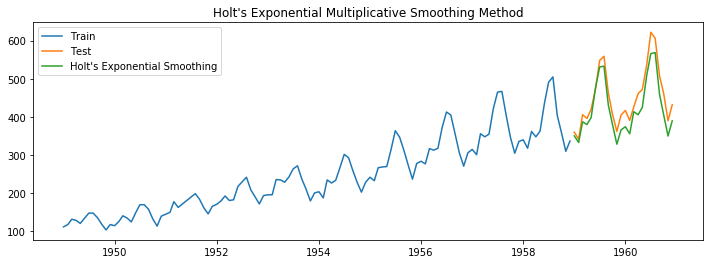

In [137]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_hwm['hwm_forecast'], label='Holt\'s Exponential Smoothing')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Multiplicative Smoothing Method')
plt.show()

### <span style='color:green'>From the output we can see that there is a good capture of Level, Trend and Seasonality.

# Calculate RMSE and MAPE to evaluate forecast

In [138]:
# mean_squared_error gives MSE , since we need RMSE take square root of MSE
# Since we are calculating for the whole data set, we need to select only test data in y_hat_sma
rmse = np.sqrt(mean_squared_error(test['Passengers'],
                                       y_hat_hwm['hwm_forecast'])).round(2)
rmse

34.81

In [139]:
# To Calculate MAPE
#we need to select only test data in y_hat_sma
mape = np.round(np.mean(np.abs(test['Passengers'] - 
                               y_hat_hwm['hwm_forecast'])/test['Passengers'])*100,2)
mape

6.91

In [140]:
tempResults = pd.DataFrame({'Method':['Holt\'s Winters\'s Multiplicative Smoothing Method'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28
0,Simple Moving Average Method,103.33,15.54
0,Simple Exponential Smoothing Method,107.65,16.49
0,Holt's Exponential Smoothing Method,71.94,11.11
0,Holt's Winters's Smoothing Method,35.10,6.53
0,Holt's Winters's Multiplicative Smoothing Method,34.81,6.91


### Here the MAPE is strange, we got more value because even a single deviation will affect , where as in RMSE since we are taking square root it is getting penalized.  
## <span style='color:green'> Overall both additive and multiplicate works well.

<hr/>

# <span style='color:#0099cc'> Auto Regressive models

## <span style='color:purple'> Stationary vs non-stationary time series

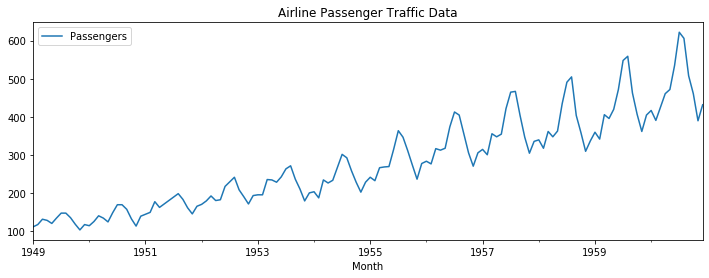

In [141]:
data['Passengers'].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Airline Passenger Traffic Data')
plt.show()

- we can see the trend is upwards so **mean is not constant**
- The fluctuation is low at the begining and more at the end **Variance is not constant**.
- Visually it is clear that the series is not stationary, but most of the times it will not be this case, so we need to perform stationary test

# <span style='color:blue'> KPSS Test

In [142]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data['Passengers'])

# Test statistic
print('KPSS statistic : %f' %kpss_test[0])
print('Critical Value @ 0.05 : %.2f'%kpss_test[3]['5%'])

#p-value
print('p-value: %f'%kpss_test[1])

KPSS statistic : 1.052050
Critical Value @ 0.05 : 0.46
p-value: 0.010000


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


### Since `p-value` is less than 0.05 i.e., 0.01 we will <span style='color:green'>reject</span> the null hypothesis. The Series is <span style='color:red'>not stationary</span>

Remember : H0 is different for both tests.

# <span style='color:blue'> Augmented Dickey-Fuller (ADF) test

In [143]:
# It is available in the stats model under tsa : time series package 
# adfuller means Augumented Dickey Fuller
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Passengers'])

# Test statistic
print('ADF statistic : %f' %adf_test[0])
print('Critical Value @ 0.05 : %.2f'%adf_test[4]['5%'])

#p-value
print('p-value: %f'%adf_test[1])

ADF statistic : 0.894609
Critical Value @ 0.05 : -2.88
p-value: 0.993020


### `p-value` is greater than 0.05 i.e., **0.99** so we will <span style='color:red'>fail</span> to reject the null hypothesis. The Series is <span style='color:red'>not stationary</span>

# <span style='color:#0099cc'>Box Cox Transformation

Transforming the data using boxcox and a lambda value of 0. That is **log(y)**.
- Here it is used as `lmbda` no **a**

In [144]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Passengers'],lmbda=0),index=data.index)

#### Plotting the tranformed series

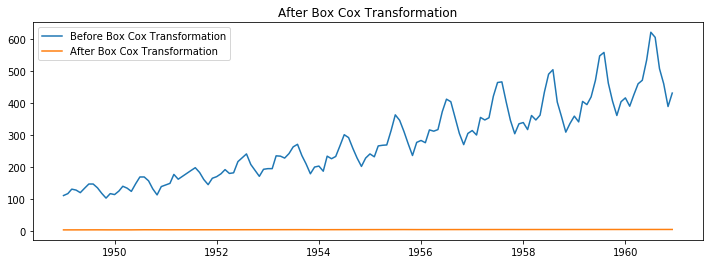

In [145]:
plt.figure(figsize=(12,4))
plt.plot(data['Passengers'], label='Before Box Cox Transformation')
plt.plot(data_boxcox, label='After Box Cox Transformation')

plt.legend(loc='best')
plt.title('After Box Cox Transformation')
plt.show()

Transformed values are too low, so it is a straight line, so we will plot only Transformed series

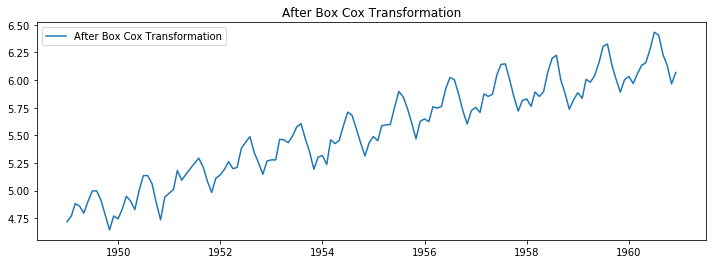

In [146]:
plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox Transformation')

plt.legend(loc='best')
plt.title('After Box Cox Transformation')
plt.show()

- Previously we had the small fluctuations at the beginning and a big one at the end(Previous graph).
- Now the variance is constant.
- Still we have the trend, to take the trend out we need to do **differencing**.

# <span style='color:#0099cc'>Differencing

In [150]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index= data.index)
data_boxcox_diff.head()

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
dtype: float64

As you know the first value is **NAN** we need to drop that row.

In [151]:
data_boxcox_diff.dropna(inplace=True)

### Plot

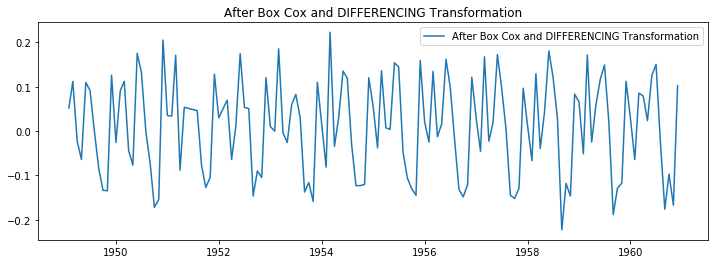

In [152]:
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox and DIFFERENCING Transformation')

plt.legend(loc='best')
plt.title('After Box Cox and DIFFERENCING Transformation')
plt.show()

Visually this looks a lot more **Stationary**. Let's try the KPSS and ADF test to confirm about the same.

# <span style='color:blue'> Augmented Dickey-Fuller (ADF) test

In [153]:
# It is available in the stats model under tsa : time series package 
# adfuller means Augumented Dickey Fuller
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data_boxcox_diff)

# Test statistic
print('ADF statistic : %f' %adf_test[0])
print('Critical Value @ 0.05 : %.2f'%adf_test[4]['5%'])

#p-value
print('p-value: %f'%adf_test[1])

ADF statistic : -3.290114
Critical Value @ 0.05 : -2.88
p-value: 0.015326


### `p-value` is less than 0.05 i.e., **0.01** so we will <span style='color:green'>reject</span>   the null hypothesis. The Series is <span style='color:green'>**stationary**</span>

- Also we can make decision using **ADF statistic** which is less than **Critical Value** then the series is **Stationary**

# <span style='color:blue'> KPSS Test

In [154]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data_boxcox_diff)

# Test statistic
print('KPSS statistic : %f' %kpss_test[0])
print('Critical Value @ 0.05 : %.2f'%kpss_test[3]['5%'])

#p-value
print('p-value: %f'%kpss_test[1])

KPSS statistic : 0.101871
Critical Value @ 0.05 : 0.46
p-value: 0.100000


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


### Since `p-value` is greater than 0.05 i.e., 0.10 we will <span style='color:red'>fail to</span> reject the null hypothesis. The Series is <span style='color:green'> stationary</span>

## <span style='color:green'> From both tests it is clear that the series is Stationary, which is the first requirement for building the Auto Regressive Series

<hr/>

# <span style='color:#0099cc'> Auto Correlation Function(ACF) Plot

- from `tsaplots` need to use **plot_acf**

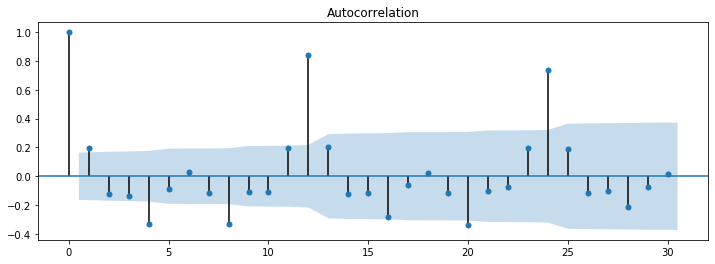

In [155]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

Any line outside the blue mark is highly correlated.

# <span style='color:#0099cc'> Partial AutoCorrelation Function (PACF) Plot

- Need to use **plot_pacf**

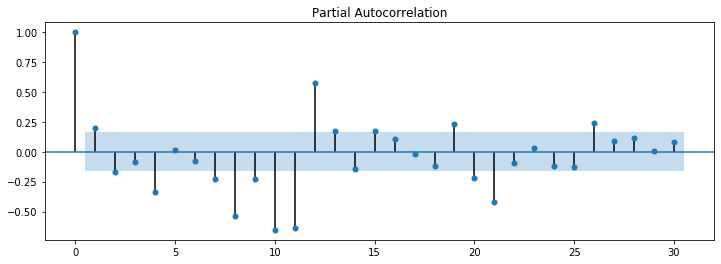

In [156]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

# <span style='color:#0099cc'> The Simple Auto Regressive Model (AR)

Now let us get back again to the airline passenger dataset and build an AR model on it.  In order to build the AR model, the stationary series is divided into train and test data.

### Split into Training and Test data sets

Remember we have two series,
- `data_boxcox` only boxcox transformation
- `data_boxcox_diff` boxcox transformation and differencing

In [157]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]

Remember in the `data_boxcox_diff` after `shift()` we have dropped the first observation because x - **nan** = **nan**.
- So we will use `train_len - 1`.

In [158]:
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox = data_boxcox[train_len-1:]

### Simple Auto Regression Method (AR)

We are building AR model but still we have imported **ARIMA**(`arima_model`), if we set only **AR** parameter which is the **lag order** from the **ARIMA** we will get AR model.

In [159]:
from statsmodels.tsa.arima_model import ARIMA

# Since we are building AR Model we will set only AR parameter(lag order).
# Here we are using the lag order of 1
model = ARIMA(train_data_boxcox_diff,order=(1,0,0))
model_fit = model.fit()
print(model_fit.params)

const      0.009477
ar.L1.y    0.183116
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


- Here the constant beta0 is almost equal to 0 as we got the series after differencing has a mean very close to 0.
- Beta 1 is 0.183116

### You have built the model now, but you do not have any idea what the forecast looks like.  Also, recall that you had performed boxcox transformation and differencing in order to convert the airline passenger data into a stationary time-series. Now in order to recover the original forecast, you will have to reverse these transformations. 

# <span style='color:#0099cc'> Recover Original Time Series Forecast

#### Let's copy the `data_boxcox_diff` and predict the forecast on the stationary series

In [160]:
y_hat_ar = data_boxcox_diff.copy()

In [161]:
y_hat_ar.head(5)

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
dtype: float64

#### Here we are predicting using `predict( )` , also we need to give the range, remember the date is the index, here we are giving the whole dataset to predict

In [162]:
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),
                                                       data_boxcox_diff.index.max())

#### Now we need to forecast on the original series. So we need to go step by step. <br/> Here we are using the `cumsum( )` which will calculate the cumulative sum, because in differencing we subracted each term from previous. <br/> In maths analogy we can tell that we are doing integration as we previously did differentiation.

In [163]:
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()

#### Add the first term as we lost after differencing. Here we will add the first term after we got box cox transformation.

In [164]:
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])

#### Now reverse translate i.e., from boxcox to original series. <br/> Boxcox means just logarithmic transformation. So to reverse that by anti log which is exponential 

Will call the original prediction as `ar_forecast`

In [165]:
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

### Plot train,test and forecast

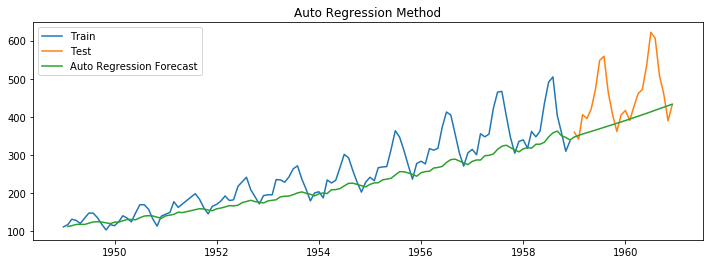

In [166]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_ar['ar_forecast'], label='Auto Regression Forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

### Just to show how it performed on test data

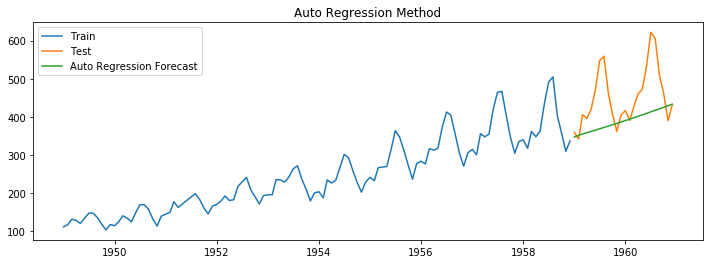

In [167]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto Regression Forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

#### With the simple Auto Regressive model, we are able to predict the level and trend. But still seasonality should be captured.

# Calculate RMSE and MAPE to evaluate forecast

In [168]:
# mean_squared_error gives MSE , since we need RMSE take square root of MSE
# Since we are calculating for the whole data set, we need to select only test data in y_hat_sma
rmse = np.sqrt(mean_squared_error(test['Passengers'],
                                       y_hat_ar['ar_forecast'][test.index.min():])).round(2)
rmse

93.39

In [169]:
# To Calculate MAPE
#we need to select only test data in y_hat_sma
mape = np.round(np.mean(np.abs(test['Passengers'] - 
                               y_hat_ar['ar_forecast'][test.index.min():])/test['Passengers'])*100,2)
mape

13.77

In [170]:
tempResults = pd.DataFrame({'Method':['Auto Regression Method'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28
0,Simple Moving Average Method,103.33,15.54
0,Simple Exponential Smoothing Method,107.65,16.49
0,Holt's Exponential Smoothing Method,71.94,11.11
0,Holt's Winters's Smoothing Method,35.10,6.53
0,Holt's Winters's Multiplicative Smoothing Method,34.81,6.91
0,Auto Regression Method,93.39,13.77


#### When we compare with the simple models like Simple Average method , Auto Regressive model is better. <br/>But when we compare with Holt's Winters it need to capture seasonality

# <span style='color:#0099cc'> Moving Average Method (MA)

<span style="font-size:25px">We are building MA model but still we are using **ARIMA**(`arima_model`), if we set only **MA** parameter which is the **q** the error made in previous forecast, from the **ARIMA** we will get MA model.</span>
- <span style="font-size:20px">To reiterate we will apply the model on stationary series and then we will reverse it.</span>
- <span style="font-size:20px"> Here the q paramter is set to 1, i.e., error of last one observation is considered.

In [171]:
model = ARIMA(train_data_boxcox_diff, order=(0,0,1))
model_fit = model.fit()
print(model_fit.params)

const      0.009538
ma.L1.y    0.266103
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


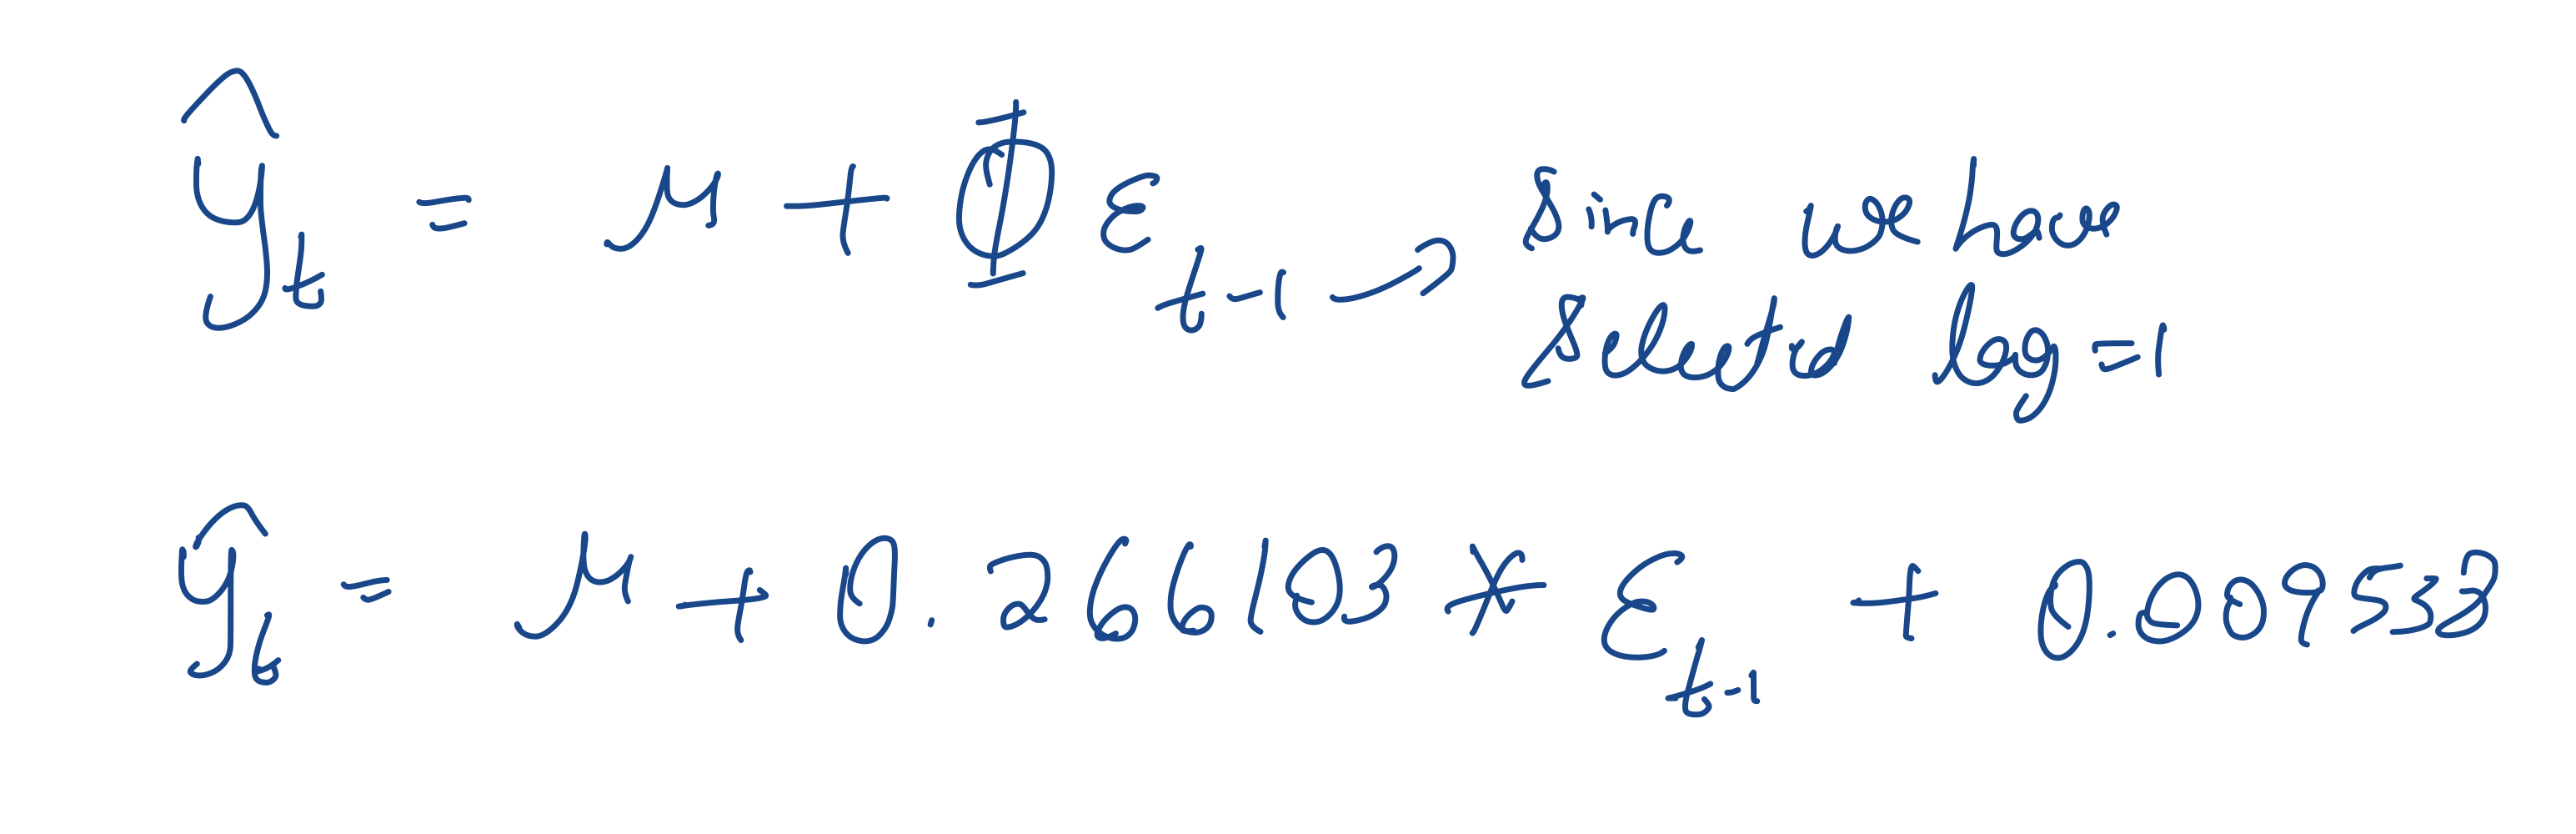

# <span style='color:#0099cc'> Recover Original Time Series Forecast

<span style="font-size:20px">Let's copy the `data_boxcox_diff` and predict the forecast on the stationary series

In [172]:
y_hat_ma = data_boxcox_diff.copy()

In [173]:
y_hat_ma.head(5)

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
dtype: float64

<span style="font-size:20px">Here we are predicting using `predict( )` , also we need to give the range, remember the date is the index, here we are giving the whole dataset to predict

In [174]:
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),
                                                       data_boxcox_diff.index.max())

<span style="font-size:20px">Now we need to forecast on the original series. So we need to go step by step. <br/> Here we are using the `cumsum( )` which will calculate the cumulative sum, because in differencing we subracted each term from previous. <br/> In maths analogy we can tell that we are doing integration as we previously did differentiation.

In [175]:
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()

<span style="font-size:20px">Add the first term as we lost after differencing. Here we will add the first term after we got box cox transformation.

In [176]:
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])

<span style="font-size:20px">Now reverse translate i.e., from boxcox to original series. <br/> Boxcox means just logarithmic transformation. So to reverse that by anti log which is exponential 

<span style="font-size:20px">Will call the original prediction as `ma_forecast`

In [177]:
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

### Plot train,test and forecast

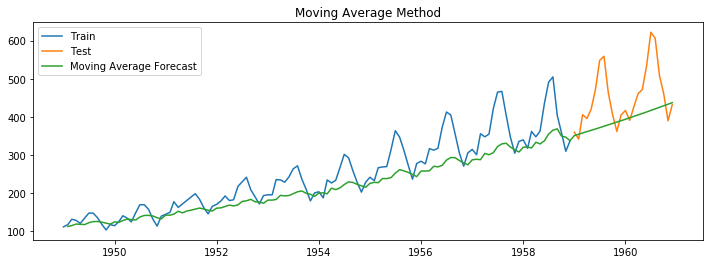

In [178]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_ma['ma_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

### Just to show how it performed on test data

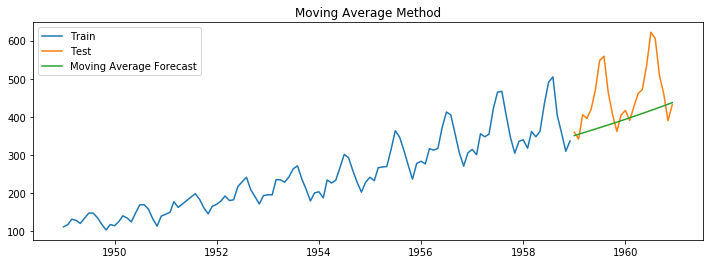

In [179]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving Average Forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

<span style="font-size:20px">The **MA(1)** model looks similar to the previous AR model, able to predict the level and trend. But still seasonality should be captured.

# Calculate RMSE and MAPE to evaluate forecast

In [180]:
# mean_squared_error gives MSE , since we need RMSE take square root of MSE
# Since we are calculating for the whole data set, we need to select only test data in y_hat_sma
rmse = np.sqrt(mean_squared_error(test['Passengers'],
                                       y_hat_ma['ma_forecast'][test.index.min():])).round(2)
rmse

91.21

In [181]:
# To Calculate MAPE
#we need to select only test data in y_hat_sma
mape = np.round(np.mean(np.abs(test['Passengers'] - 
                               y_hat_ma['ma_forecast'][test.index.min():])/test['Passengers'])*100,2)
mape

13.39

In [182]:
tempResults = pd.DataFrame({'Method':['Moving Average Method'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28
0,Simple Moving Average Method,103.33,15.54
0,Simple Exponential Smoothing Method,107.65,16.49
0,Holt's Exponential Smoothing Method,71.94,11.11
0,Holt's Winters's Smoothing Method,35.10,6.53
0,Holt's Winters's Multiplicative Smoothing Method,34.81,6.91
0,Auto Regression Method,93.39,13.77
0,Moving Average Method,91.21,13.39


<span style='font-size:15px'> The RMSE and MAPE is less when compared to Auto Regression Method.

# <span style='color:#0099cc'> Auto Regressive Moving Average (ARMA) Method

<span style="font-size:25px">We are building the model using **ARIMA**(`arima_model`)
- <span style="font-size:20px">To reiterate we will apply the model on stationary series and then we will reverse it.</span>
- <span style="font-size:20px"> Here the p paramter is set to 1, i.e., last one observation value is considered.Similarly the q paramter is set to 1, i.e., error of last one observation is considered.

Note it is (1,0,1) 

In [183]:
model = ARIMA(train_data_boxcox_diff,order=(1,0,1))
model_fit = model.fit()
print(model_fit.params)

const      0.009624
ar.L1.y   -0.527115
ma.L1.y    0.798281
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


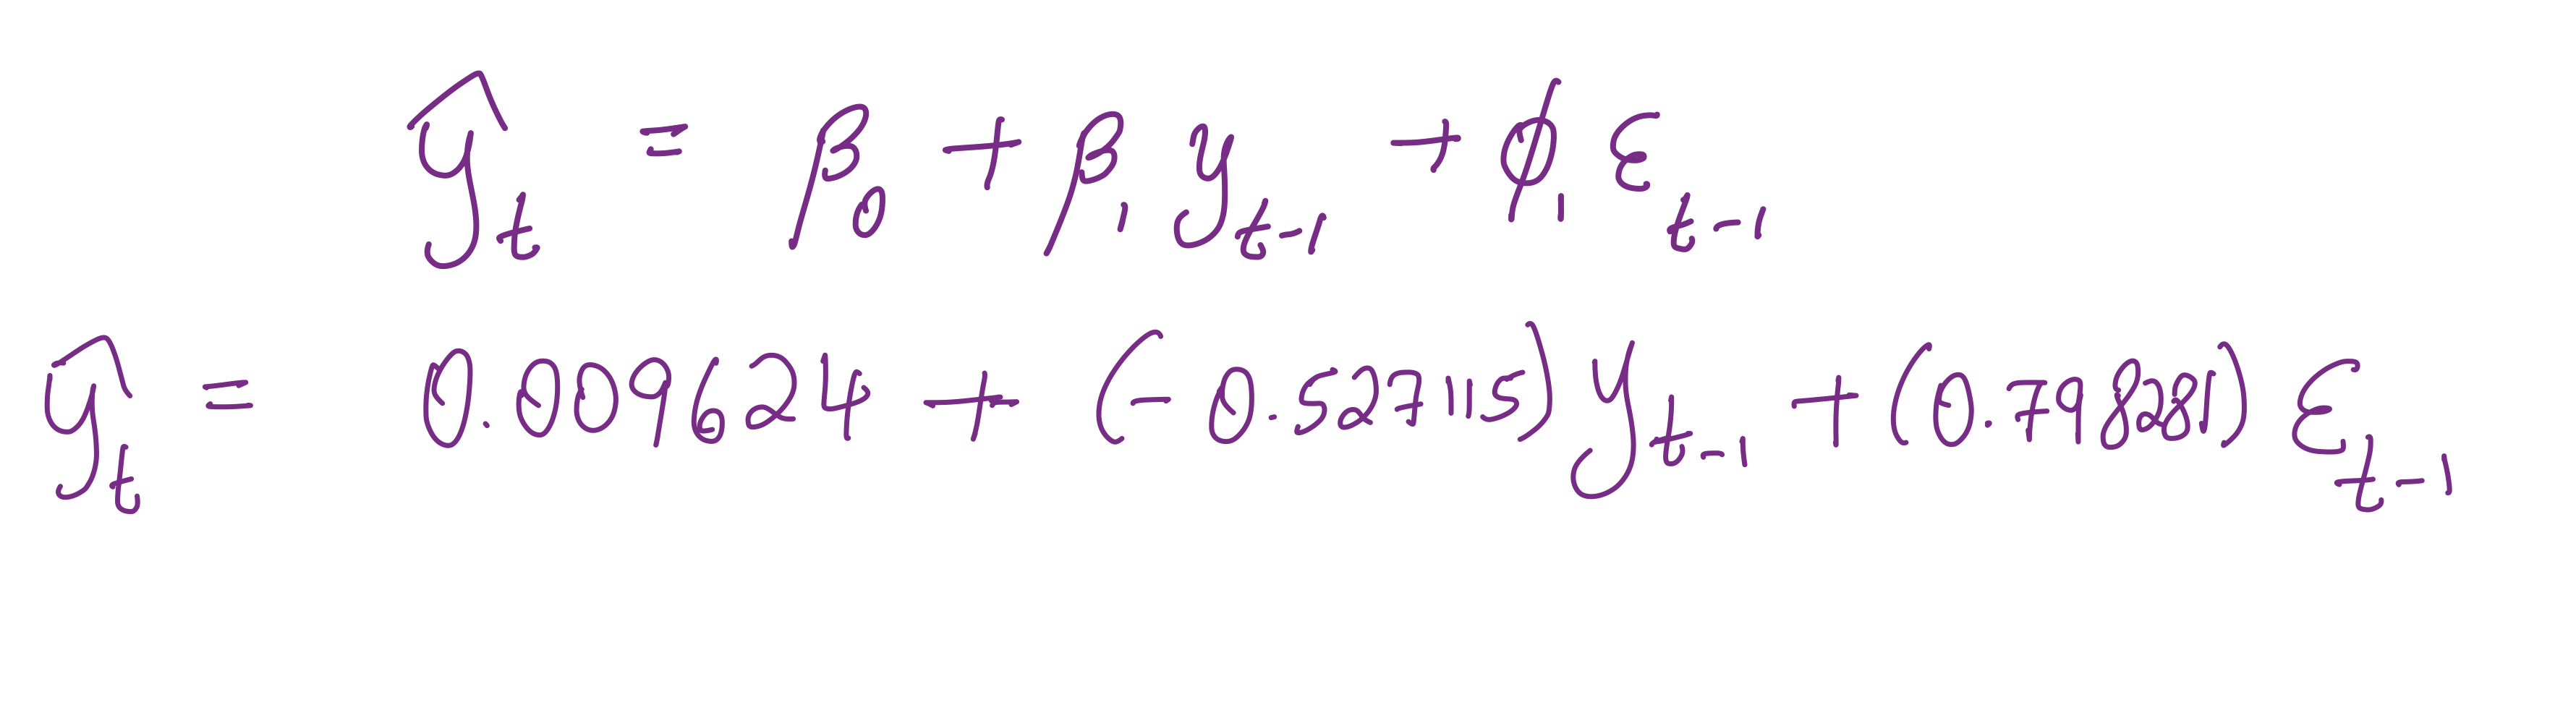

# <span style='color:#0099cc'> Recover Original Time Series Forecast

<span style="font-size:20px">Let's copy the `data_boxcox_diff` and predict the forecast on the stationary series

In [184]:
y_hat_arma = data_boxcox_diff.copy()

In [185]:
y_hat_arma.head(5)

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
dtype: float64

<span style="font-size:20px">Here we are predicting using `predict( )` , also we need to give the range, remember the date is the index, here we are giving the whole dataset to predict

In [186]:
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),
                                                       data_boxcox_diff.index.max())

<span style="font-size:20px">Now we need to forecast on the original series. So we need to go step by step. <br/> Here we are using the `cumsum( )` which will calculate the cumulative sum, because in differencing we subracted each term from previous. <br/> In maths analogy we can tell that we are doing integration as we previously did differentiation.<br/> Previously we did boxcox and then differencing, so we need to get back to original by first removing the differencing and then boxcox

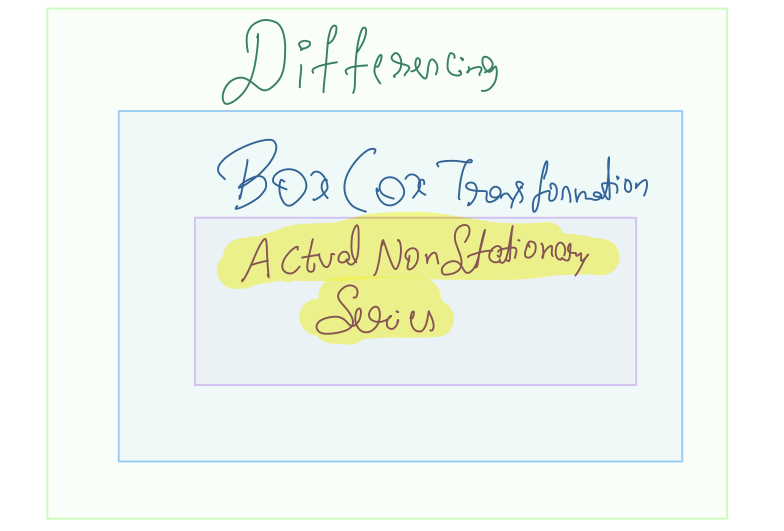

In [187]:
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()

<span style="font-size:20px">Add the first term as we lost after differencing. Here we will add the first term after we got box cox transformation.

In [188]:
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])

<span style="font-size:20px">Now reverse translate i.e., from boxcox to original series. <br/> Boxcox means just logarithmic transformation. So to reverse that by anti log which is exponential 

<span style="font-size:20px">Will call the original prediction as `arma_forecast`

In [189]:
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plot train,test and forecast

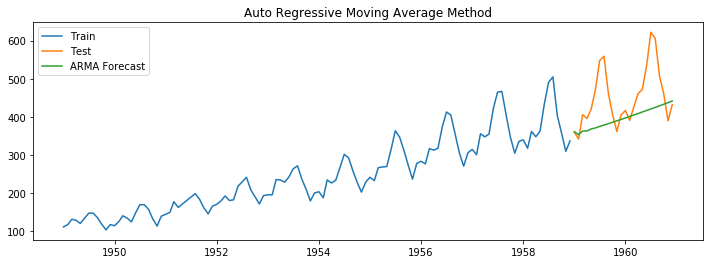

In [190]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA Forecast')
plt.legend(loc='best')
plt.title('Auto Regressive Moving Average Method')
plt.show()

<span style="font-size:20px">The **ARMA(1,1)** model looks similar to the previous AR model, able to predict the level and trend. But still seasonality should be captured.

# Calculate RMSE and MAPE to evaluate forecast

In [191]:
# mean_squared_error gives MSE , since we need RMSE take square root of MSE
# Since we are calculating for the whole data set, we need to select only test data in y_hat_sma
rmse = np.sqrt(mean_squared_error(test['Passengers'],
                                       y_hat_arma['arma_forecast'][test.index.min():])).round(2)
rmse

88.88

In [192]:
# To Calculate MAPE
#we need to select only test data in y_hat_sma
mape = np.round(np.mean(np.abs(test['Passengers'] - 
                               y_hat_arma['arma_forecast'][test.index.min():])/test['Passengers'])*100,2)
mape

12.89

In [193]:
tempResults = pd.DataFrame({'Method':['ARMA Method'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28
0,Simple Moving Average Method,103.33,15.54
0,Simple Exponential Smoothing Method,107.65,16.49
0,Holt's Exponential Smoothing Method,71.94,11.11
0,Holt's Winters's Smoothing Method,35.10,6.53
0,Holt's Winters's Multiplicative Smoothing Method,34.81,6.91
0,Auto Regression Method,93.39,13.77
0,Moving Average Method,91.21,13.39
0,ARMA Method,88.88,12.89


<span style='font-size:20px'> The RMSE and MAPE is better (that is less) when compared to AR or MA method. Also it has done better than **Simple Exponential Smoothing Method** as even that captured only level and trend.

<span style='font-size:20px'> When compared with holt's method, it need to capture the seasonality.

<hr/>

# <span style='color:#0099cc'>Auto Regressive Integrated Moving Average (ARIMA) Method 

<span style='font-size:20px'> Here we are using the `train_data_boxcox`, not the `train_data_boxcox_diff` as **ARIMA** internally handles the trend by differencing. 

In [194]:
# Here the basic model p=1,d=1 and q=1
model = ARIMA(train_data_boxcox, order=(1,1,1))

model_fit = model.fit()
print(model_fit.params)

const        0.009624
ar.L1.D.y   -0.527115
ma.L1.D.y    0.798281
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


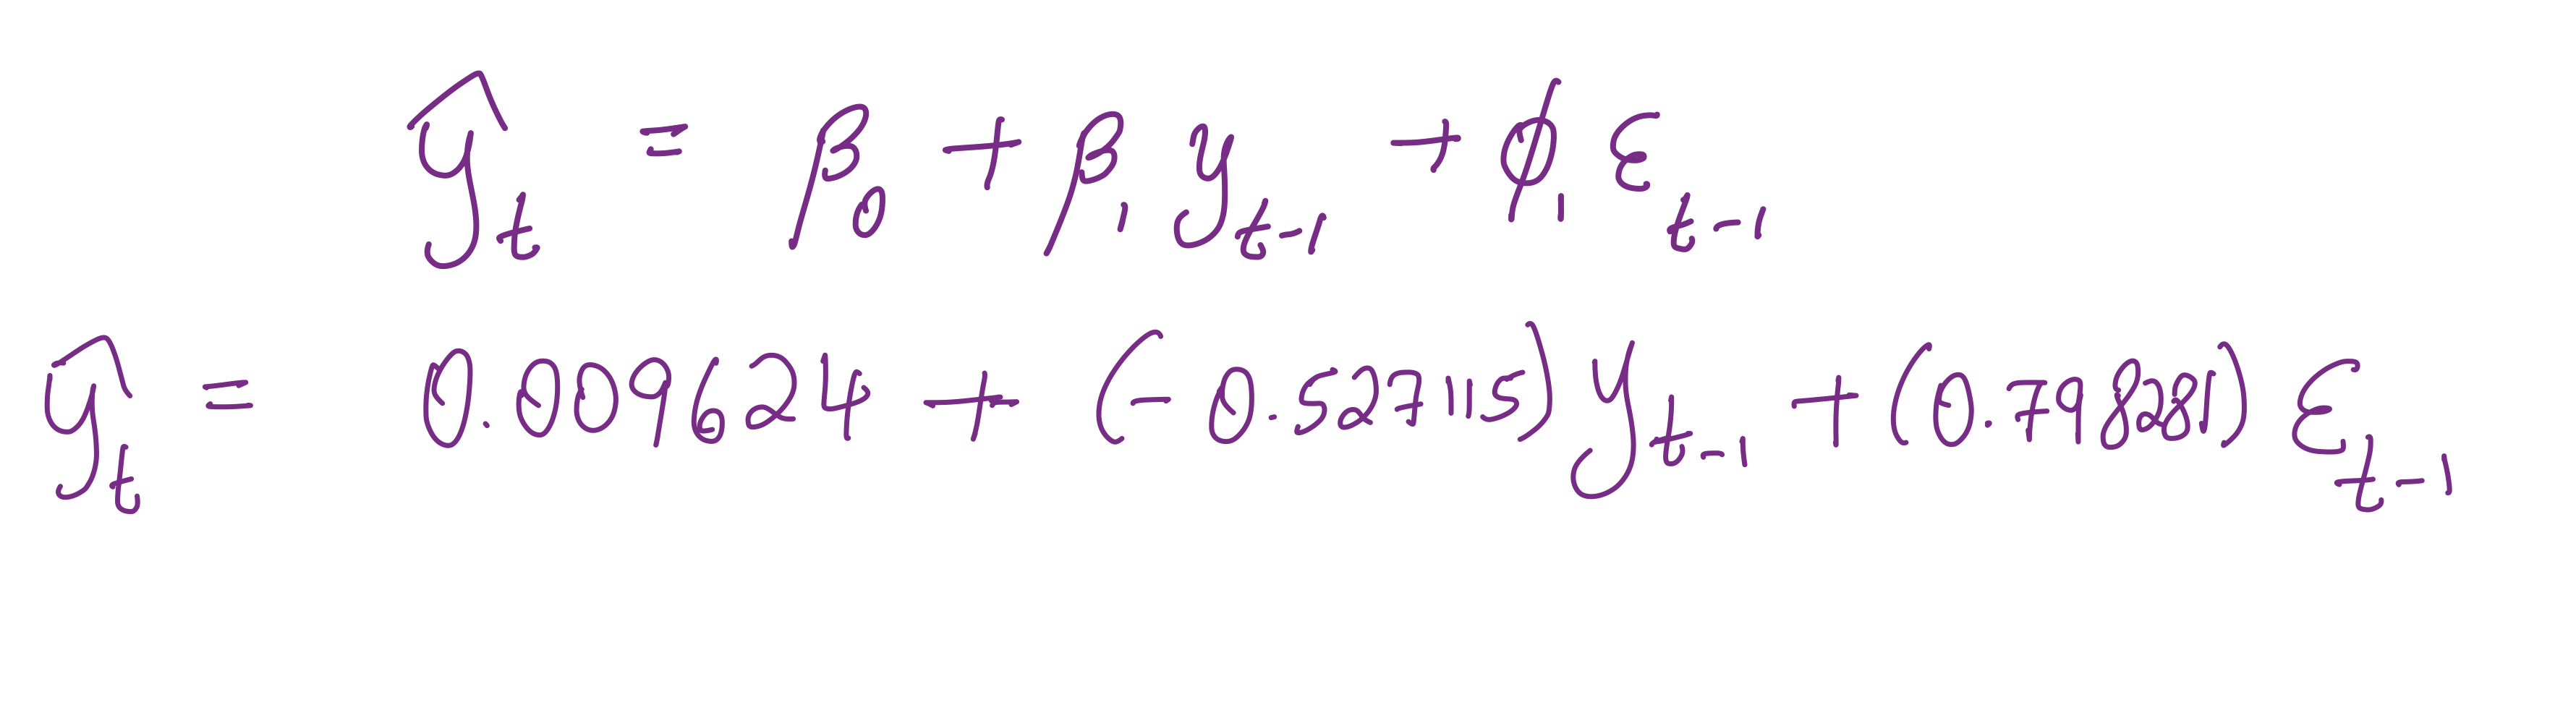

<span style='font-size:20px'> Output of **ARIMA** is same as *ARMA*. We got the same co-efficients in ARMA model<br/>

- <span style='font-size:18px'> OVERALL, ARIMA is very similar to ARMA , except in ARMA , we used to apply differencing where as in ARIMA differencing is done internally.

<span style='font-size:20px'>Note here we have used `train_data_boxcox` to fit the model(i.e., model is learned using the train data set. -> Using the previous observations of the trained data set)While predicting we will predict on the whole data set.<br/> Even we can use the full data set to fit the model `data_boxcox_diff`.

## <span style='color:#0099cc'> Recover Original Time Series Forecast

<span style="font-size:20px">Since we are predicting on the whole data set , to get the length of the dataframe ,let's copy the `data_boxcox_diff` and predict the forecast on the stationary series

In [195]:
y_hat_arima = data_boxcox_diff.copy()

In [196]:
y_hat_arima.head(5)

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
dtype: float64

<span style="font-size:20px">Here we are predicting using `predict( )` , also we need to give the range, remember the date is the index, here we are giving the whole dataset to predict

In [197]:
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),
                                                       data_boxcox_diff.index.max())

<span style="font-size:20px">Now we need to forecast on the original series. So we need to go step by step. <br/> Here we are using the `cumsum( )` which will calculate the cumulative sum, because in differencing we subracted each term from previous. <br/> In maths analogy we can tell that we are doing integration as we previously did differentiation.<br/> Previously we did boxcox and then differencing, so we need to get back to original by first removing the differencing and then boxcox

In [198]:
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()

<span style="font-size:20px">Add the first term as we lost after differencing(which is done internally). Here we will add the first term after we got box cox transformation.

In [199]:
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])

<span style="font-size:20px">Now reverse translate i.e., from boxcox to original series. <br/> Boxcox means just logarithmic transformation. So to reverse that by anti log which is exponential 

<span style="font-size:20px">Will call the original prediction as `arima_forecast`

In [200]:
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plot train,test and forecast

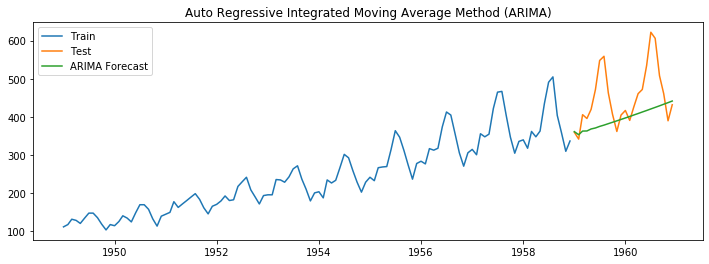

In [201]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA Forecast')
plt.legend(loc='best')
plt.title('Auto Regressive Integrated Moving Average Method (ARIMA)')
plt.show()

<span style="font-size:20px">The **ARIMA(1,1,1)** model looks exactly same as ARMA(1,1)

# Calculate RMSE and MAPE to evaluate forecast

In [202]:
# mean_squared_error gives MSE , since we need RMSE take square root of MSE
# Since we are calculating for the whole data set, we need to select only test data in y_hat_sma
rmse = np.sqrt(mean_squared_error(test['Passengers'],
                                       y_hat_arima['arima_forecast'][test.index.min():])).round(2)
rmse

88.88

In [203]:
# To Calculate MAPE
#we need to select only test data in y_hat_sma
mape = np.round(np.mean(np.abs(test['Passengers'] - 
                               y_hat_arima['arima_forecast'][test.index.min():])/test['Passengers'])*100,2)
mape

12.89

In [204]:
tempResults = pd.DataFrame({'Method':['ARIMA Average Method'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28
0,Simple Moving Average Method,103.33,15.54
0,Simple Exponential Smoothing Method,107.65,16.49
0,Holt's Exponential Smoothing Method,71.94,11.11
0,Holt's Winters's Smoothing Method,35.10,6.53
0,Holt's Winters's Multiplicative Smoothing Method,34.81,6.91
0,Auto Regression Method,93.39,13.77
0,Moving Average Method,91.21,13.39
0,ARMA Method,88.88,12.89


<span style='font-size:20px'> The RMSE and MAPE same as ARMA , as nothing differenct except the integrated differencing

<hr/>

# <span style='color:#0099cc'> Seasonal Auto Regressive Integrated Moving Average (SARIMA)

<span style='font-size:20px'> Here we are using `SARIMAX` , about **X** we will learn later.
- <span style='font-size:20px'>Here we are passing the boxcox transformed data , as SARIMA has integrated differencing.
- <span style='font-size:20px'> `order` : is non seasonal parameters p,d,q
- <span style='font-size:20px'> `seasonal_order` : is seasonal parameters P D Q and **m**. Here the value of **m** is 12, as seasonality repeats after each month in a year.

In [205]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()
print(model_fit.params)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ar.L1       0.393192
ma.L1      -0.683118
ar.S.L12   -0.038836
ma.S.L12   -0.519432
sigma2      0.001408
dtype: float64


<span style='font-size:20px'> Here the non seasonal parameters are with lag 1, so `ar.L1` and `ma.L1`<br/> Where as the seasonal paramters are with lag 12 even though we have given value of P,D,Q as 1. It is because of the **m** value which is 
    - P * m(1 * 12 = 12), 
    - Q * m (1 * 12 = 12), 
    - D * m (1 * 12 = 12)

## <span style='color:#0099cc'> Recover Original Time Series Forecast

<span style="font-size:20px">Since we are predicting on the whole data set , to get the length of the dataframe ,let's copy the `data_boxcox_diff` and predict the forecast on the stationary series

In [206]:
y_hat_sarima = data_boxcox_diff.copy()

In [207]:
y_hat_sarima.head(5)

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
dtype: float64

<span style="font-size:20px"> <span style='color:green'>The difference with SARIMAX is that the forecast we get integrated series, that is the series with cumulative sum to remove the differencing. We get `sarima_forecast_boxcox` NOT `sarima_forecast_boxcox_diff`
- <span style="font-size:20px">Also the first term as we lost after differencing(which is done internally). Will be added to the series

In [208]:
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(),
                                                       data_boxcox_diff.index.max())

<span style="font-size:20px">Now reverse translate i.e., from boxcox to original series. <br/> Boxcox means just logarithmic transformation. So to reverse that by anti log which is exponential 

<span style="font-size:20px">Will call the original prediction as `arima_forecast`

In [209]:
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train,test and forecast

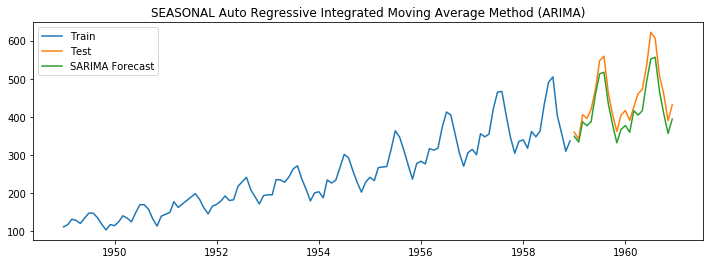

In [210]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.title('SEASONAL Auto Regressive Integrated Moving Average Method (ARIMA)')
plt.show()

<span style="font-size:20px">The **SARIMA** model is predicting the seasonality , trend and level.

# Calculate RMSE and MAPE to evaluate forecast

In [211]:
# mean_squared_error gives MSE , since we need RMSE take square root of MSE
# Since we are calculating for the whole data set, we need to select only test data in y_hat_sma
rmse = np.sqrt(mean_squared_error(test['Passengers'],
                                       y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
rmse

37.45

In [212]:
# To Calculate MAPE
#we need to select only test data in y_hat_sma
mape = np.round(np.mean(np.abs(test['Passengers'] - 
                               y_hat_sarima['sarima_forecast'][test.index.min():])/test['Passengers'])*100,2)
mape

7.35

In [213]:
tempResults = pd.DataFrame({'Method':['SARIMA Average Method'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28
0,Simple Moving Average Method,103.33,15.54
0,Simple Exponential Smoothing Method,107.65,16.49
0,Holt's Exponential Smoothing Method,71.94,11.11
0,Holt's Winters's Smoothing Method,35.10,6.53
0,Holt's Winters's Multiplicative Smoothing Method,34.81,6.91
0,Auto Regression Method,93.39,13.77
0,Moving Average Method,91.21,13.39
0,ARMA Method,88.88,12.89


<span style="font-size:20px"> We got a less RMSE and MAPE, which is good. If we change the values of P,Q,D,p,q,d we will get even lesser value.

<hr/>

# <span style='color:#0099cc'> Seasonal Auto Regressive Integrated Moving Average With EXTERNAL VARAIBLES (SARIMAX)

<span style='font-size:20px'> We need to the promotional data,as we are using external variable(Exogenous variable).

Header is none ,as we don't have headers and proper column names are given.

In [214]:
promo = pd.read_csv('promotion.csv',header=None)
promo.columns = ['Month','Event']

In [215]:
promo.head()

,Month,Event
0,1949-01,0
1,1949-02,0
2,1949-03,0
3,1949-04,0
4,1949-05,0


<span style='font-size:20px'> 0 for Non promotion and <br/>1 for Promotion

In [216]:
promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   144 non-null    object
 1   Event   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


<span style='font-size:20px'> As the `Month` column is of type object, we need to change it to date format. And set the month column as index.

In [217]:
promo['Month'] = pd.to_datetime(promo['Month'],format='%Y-%m')

promo = promo.set_index('Month')

promo.head()

,Event
Month,
1949-01-01,0
1949-02-01,0
1949-03-01,0
1949-04-01,0
1949-05-01,0


## <span style='font-size:20px'> Split the data into Train and Test

In [218]:
promo_train = promo[:train_len]
promo_test = promo[train_len:]

<span style='font-size:20px'> Here we are using `SARIMAX` , here  **X** is the Exogenous variable(**promo**)
- <span style='font-size:20px'>Here we are passing the boxcox transformed data , as SARIMA has integrated differencing.
- <span style='font-size:20px'> `order` : is non seasonal parameters p,d,q
- <span style='font-size:20px'> `seasonal_order` : is seasonal parameters P D Q and **m**. Here the value of **m** is 12, as seasonality repeats after each month in a year.
- <span style='font-size:20px'> `exog` is the Exogenous variable which is another name for external variable.

In [219]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12),exog = promo_train)
model_fit = model.fit()
print(model_fit.params)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Event       0.034345
ar.L1       0.479813
ma.L1      -0.742692
ar.S.L12   -0.064175
ma.S.L12   -0.557874
sigma2      0.001335
dtype: float64


<span style='font-size:20px'> **Here the new value is `Event 0.034345` which is alpha, which is multiplied with the external variable.**</span><br/><br/>
<span style='font-size:20px'> The non seasonal parameters are with lag 1, so `ar.L1` and `ma.L1`<br/> Where as the seasonal paramters are with lag 12 even though we have given value of P,D,Q as 1. It is because of the **m** value which is 
    - P * m(1 * 12 = 12), 
    - Q * m (1 * 12 = 12), 
    - D * m (1 * 12 = 12)

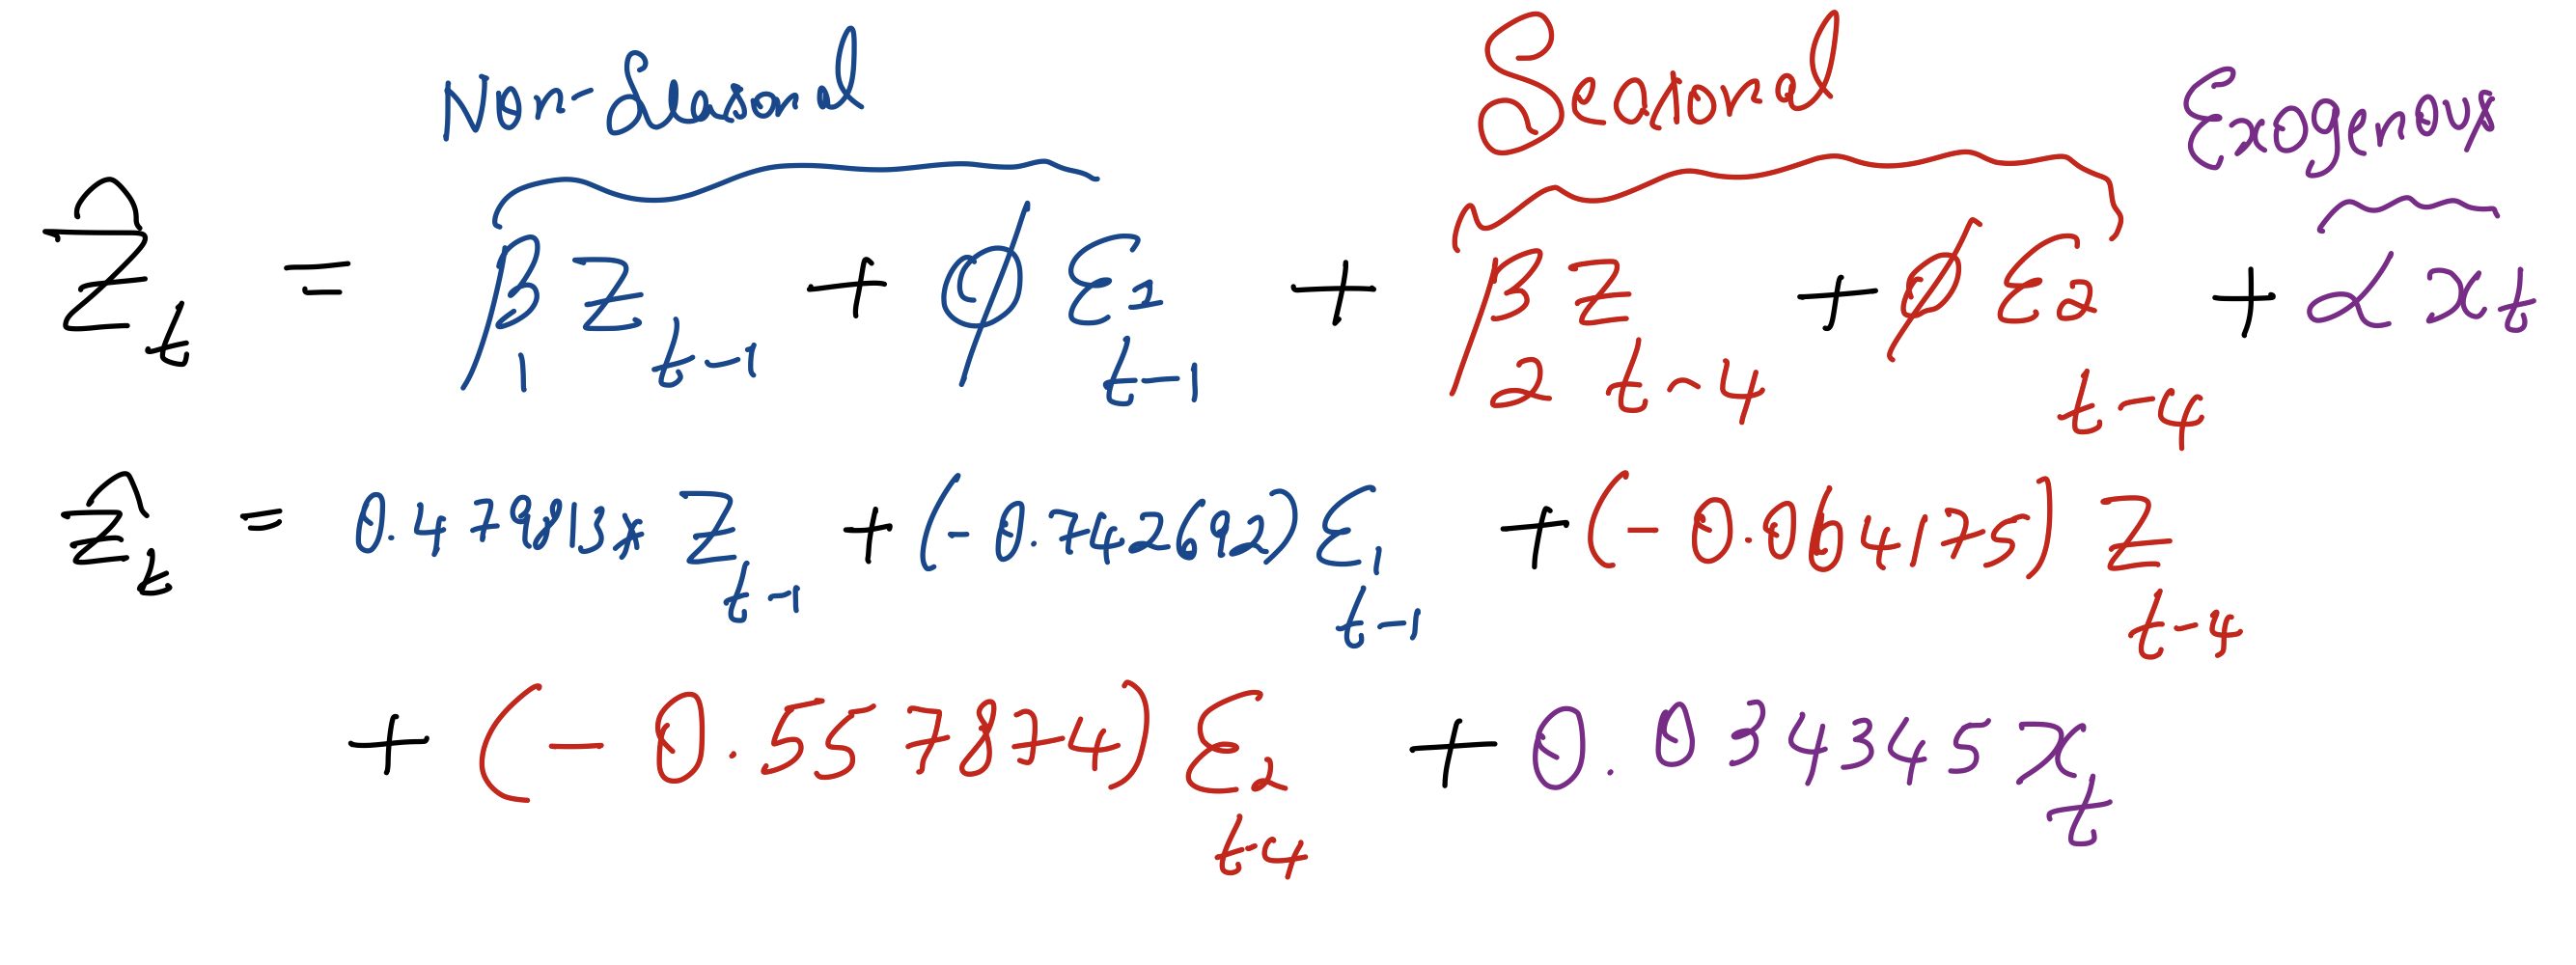

## <span style='color:#0099cc'> Recover Original Time Series Forecast

<span style="font-size:20px">Since we are predicting on the whole data set , to get the length of the dataframe ,let's copy the `data_boxcox_diff` and predict the forecast on the stationary series

In [220]:
y_hat_sarimax = data_boxcox_diff.copy()

In [221]:
y_hat_sarimax.head(5)

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
dtype: float64

<span style="font-size:20px"> <span style='color:green'>Same as SARIMA ,  SARIMAX forecast we get, is the integrated series, that is the series with cumulative sum to remove the differencing. Thus get `sarima_forecast_boxcox` NOT `sarima_forecast_boxcox_diff`
- <span style="font-size:20px">Also the first term as we lost after differencing(which is done internally). Will be added to the series

### <span style="font-size:20px"><span style='color:red'> Here we need to the pass the `exog` and we need to pass the value is `promo_test`

## Here we are precdicting only on test data, so test.index.min( ) and test.index.max( ) , also exog we are passing only test set of promo dataframe.

In [222]:
y_hat_sarimax['sarimax_forecast_boxcox'] = model_fit.predict(test.index.min(),
                                                       test.index.max(),exog=promo_test)

<span style="font-size:20px">Now reverse translate i.e., from boxcox to original series. <br/> Boxcox means just logarithmic transformation. So to reverse that by anti log which is exponential 

<span style="font-size:20px">Will call the original prediction as `arima_forecast`

In [223]:
y_hat_sarimax['sarimax_forecast'] = np.exp(y_hat_sarimax['sarimax_forecast_boxcox'])

### Plot train,test and forecast

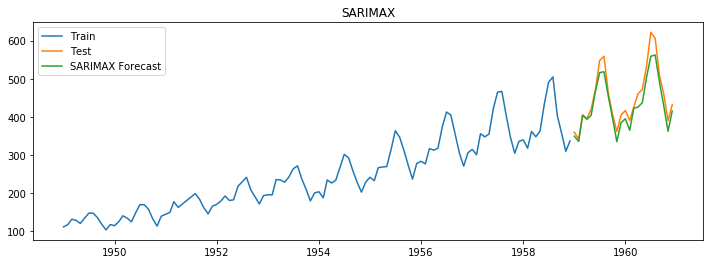

In [224]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_sarimax['sarimax_forecast'][test.index.min():], label='SARIMAX Forecast')
plt.legend(loc='best')
plt.title('SARIMAX')
plt.show()

<span style="font-size:20px">The **SARIMAX** model is predicting better seasonality , trend and level.

# Calculate RMSE and MAPE to evaluate forecast

In [225]:
# mean_squared_error gives MSE , since we need RMSE take square root of MSE
# Since we are calculating for the whole data set, we need to select only test data in y_hat_sma
rmse = np.sqrt(mean_squared_error(test['Passengers'],
                                       y_hat_sarimax['sarimax_forecast'][test.index.min():])).round(2)
rmse

26.6

In [226]:
# To Calculate MAPE
#we need to select only test data in y_hat_sma
mape = np.round(np.mean(np.abs(test['Passengers'] - 
                               y_hat_sarimax['sarimax_forecast'][test.index.min():])/test['Passengers'])*100,2)
mape

4.65

In [227]:
tempResults = pd.DataFrame({'Method':['SARIMAX Average Method'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28
0,Simple Moving Average Method,103.33,15.54
0,Simple Exponential Smoothing Method,107.65,16.49
0,Holt's Exponential Smoothing Method,71.94,11.11
0,Holt's Winters's Smoothing Method,35.10,6.53
0,Holt's Winters's Multiplicative Smoothing Method,34.81,6.91
0,Auto Regression Method,93.39,13.77
0,Moving Average Method,91.21,13.39
0,ARMA Method,88.88,12.89


# <span style='color:green'> Highest accuracy(i.e., lowest RMSE and MAPE) is achieved using SARIMAX, with the help of promotion data.